# Speed Dating Data
https://www.kaggle.com/annavictoria/speed-dating-experiment

# 3 Feature Engineering/Pre-processing & Modeling (ver. keep chosen categorical columns), both female and male decisions


## 3.1  Imports

In [158]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("whitegrid")
# sns.set_context("poster")
import pickle
import sys 

from pandas_profiling import ProfileReport
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn.decomposition import PCA
from sklearn import metrics

import statsmodels.api as sm

import shap
shap.initjs() #%%%%% what is this for?

import collections

from sb_utils import save_file

In [159]:
# not sure if I need this
import datetime
import unicodedata
import re
from sklearn.preprocessing import scale

## 3.2 Objectives

In the data wrangling notebook, we have identified our target dependent variable as desicion of parner of the specific subject, dec_o (might also consider match, desicion from both the subject and the partner) and cleaned the data accordingly. In this notebook, we will conduct further EDA, hoping to answer following questions.

1. The difference of desirable attributes in a male partner vs female partner.
2. The difference of desirable attributes among  races.
3. The difference of desirable major of male partner vs female partner
4. The difference of desirable majors among races.  

**Learning Objectives**:
Preprocessing:
1. Understand the importance of creating a model training development data set.
2. Correctly identify when to create dummy features or one-hot encoded features.
3. Understand the importance of magnitude standardization.
4. Apply the train and test split to the development dataset effectively

Modeling:
1. Fit your models with a training dataset 
    - Use cross-validation for hyperparameter tuning
2. Review model outcomes — Iterate over additional models as needed
    - Caclulate accuracy, recall, precision, and F1.
3. Identify the final model that you think is the best model for this project
    - Most power model interms of model evaluation metrics, computational complexity, scalability, and maintenance costs.

Here is possible workflow: TBD
1. Pre-processing:
    - Removed columns with categorical meaning before fillna with mean
    - Got dummy variables for all the columns with categorical meaning and with missing data
        - Converted the type int/float to object beforehand.
        - Make sure to use pd.get_dummies(df, drop_first=False), without dropping rows with missing values. Leave the first column so that missing value information is not lost.  Missing value can be considered as a category label as its own.
        - Removed the original categorical columns with missing data
    - Split into training/test set > fill NaN with mean, scale within training set and test set separately
        - Extract columns with numeric meaning to scale
        - Removed dummy variables columns and binary columns before scaling the numeric columns
        - Combined the dummy variable columns, binary columns and scaled numeric columns per train set and test set.
    - perform PCA on scaled numeric columns to reduce dimension
        - Keep enough pca components to explain ~90% var. 
        - Combined the dummy variable columns, binary columns and pca columns from scaled numeric columns
2. Modeling:
    - logistic regression model via sklearn and statsmodel
        - Use GridSearchCV (cv=5) for feature engineering
        - Use stepwise selection, elastic-net (or L1/L2 regularizers) if possible
    - Random Forest model via sklearn
    - Compare all models using confusion matrix and classification report
3. Feature importance analysis
    - Use SHAP for sklearn model
    - in order to answer feature importance for Male and Female, ran the model with male data and female data separately (done).
    - in ordr to answer feature importance for different races, can run the model with each race seprately (not done)

## 3.3 Load The Data

In [160]:
# df = pd.read_csv('../data/ski_data_cleaned.csv')
spd = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_cleaned.csv') #spd1_2 in data wrangling notebook
spd_fp = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_FemaleRatingMale_cleaned.csv') # spd1_2fp in data wrangling notebook 
spd_mp = pd.read_csv('spd_data_wrangling_output/Speed_Dating_data_MaleRatingFemale_cleaned.csv') # spd1_2mp in data wrangling notebook

In [161]:
spd.head()

,gender,match,age,race,field,career,from,goal,int_corr,samerace,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
0,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.14,0,...,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0
1,0,0,21.0,4.0,Law,lawyer,Chicago,2.0,0.54,0,...,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0
2,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.16,1,...,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0
3,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.61,0,...,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0
4,0,1,21.0,4.0,Law,lawyer,Chicago,2.0,0.21,0,...,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0


In [162]:
spd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    6266 non-null   int64  
 1   match     6266 non-null   int64  
 2   age       6198 non-null   float64
 3   race      6208 non-null   float64
 4   field     6208 non-null   object 
 5   career    6182 non-null   object 
 6   from      6192 non-null   object 
 7   goal      6192 non-null   float64
 8   int_corr  6118 non-null   float64
 9   samerace  6266 non-null   int64  
 10  imprace   6192 non-null   float64
 11  imprelig  6192 non-null   float64
 12  age_o     6189 non-null   float64
 13  race_o    6198 non-null   float64
 14  dec_o     6266 non-null   int64  
 15  attr_o    6127 non-null   float64
 16  sinc_o    6064 non-null   float64
 17  intel_o   6054 non-null   float64
 18  fun_o     5999 non-null   float64
 19  amb_o     5709 non-null   float64
 20  shar_o    5399 non-null   floa

In [163]:
# check for NaN
spd.isna().sum() 
# need to remove cotegorical feature with type int or float before fill NaN with mean
# remove: race, goal, race_o, met_o > leave put to be dealt with dummy variables

gender        0
match         0
age          68
race         58
field        58
career       84
from         74
goal         74
int_corr    148
samerace      0
imprace      74
imprelig     74
age_o        77
race_o       68
dec_o         0
attr_o      139
sinc_o      202
intel_o     212
fun_o       267
amb_o       557
shar_o      867
like_o      162
prob_o      212
met_o       269
dtype: int64

In [164]:
# check for column value range
spd.describe()

,gender,match,age,race,goal,int_corr,samerace,imprace,imprelig,age_o,...,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
count,6266.000000,6266.000000,6198.000000,6208.000000,6192.000000,6118.000000,6266.000000,6192.000000,6192.000000,6189.000000,...,6266.000000,6127.000000,6064.000000,6054.000000,5999.000000,5709.000000,5399.000000,6104.000000,6054.000000,5997.000000
mean,0.500798,0.170763,26.257180,2.691205,2.152616,0.192596,0.405043,3.804748,3.734981,26.265148,...,0.427705,6.233132,7.223615,7.403204,6.418736,6.826152,5.554269,6.166317,5.233812,1.956145
std,0.500039,0.376332,3.525651,1.219243,1.430158,0.303994,0.490940,2.882531,2.814576,3.521609,...,0.494785,1.934149,1.717217,1.528342,1.952552,1.770204,2.141403,1.850402,2.142853,0.263864
min,0.000000,0.000000,18.000000,1.000000,1.000000,-0.830000,0.000000,1.000000,1.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,24.000000,2.000000,1.000000,-0.017500,0.000000,1.000000,1.000000,24.000000,...,0.000000,5.000000,6.000000,7.000000,5.000000,6.000000,4.000000,5.000000,4.000000,2.000000
50%,1.000000,0.000000,26.000000,2.000000,2.000000,0.210000,0.000000,3.000000,3.000000,26.000000,...,0.000000,6.000000,7.000000,8.000000,7.000000,7.000000,6.000000,6.000000,5.000000,2.000000
75%,1.000000,0.000000,28.000000,4.000000,2.000000,0.430000,1.000000,6.000000,6.000000,28.000000,...,1.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000,2.000000
max,1.000000,1.000000,42.000000,6.000000,6.000000,0.900000,1.000000,10.000000,10.000000,42.000000,...,1.000000,10.500000,10.000000,10.000000,11.000000,10.000000,10.000000,10.000000,10.000000,8.000000


In [165]:
# met_o supposed to be binary (1 or 2) column but it was not. double check its unique value
spd.met_o.unique() # people might have mistakenly input how many times have met before?

array([ 2.,  1., nan,  3.,  5.,  6.,  7.,  8.])

In [166]:
# check the value of categorical columns we want to get dummy variables
spd.race.unique()

array([ 4.,  2.,  6.,  3.,  1., nan])

In [167]:
spd.race_o.unique()

array([ 2.,  4.,  3.,  6.,  1., nan])

In [168]:
spd.field.unique() # too much but want to keep it for now

array(['Law', 'law', 'Economics', 'Masters in Public Administration',
       'Masters of Social Work&Education', 'Finance', 'Business',
       'political science', 'money', 'Operations Research',
       'TC (Health Ed)', 'Psychology', 'social work', 'Social Work',
       'Speech Language Pathology', 'Speech Languahe Pathology',
       'Educational Psychology', 'Applied Maths/Econs', 'Mathematics',
       'Statistics', 'Organizational Psychology',
       'Mechanical Engineering', 'Finanace', 'Finance&Economics',
       'Undergrad - GS', 'Mathematical Finance', 'Medicine', 'MBA', 'LAW',
       nan, 'psychology', 'German Literature',
       'Business & International Affairs', 'MFA Creative Writing',
       'Engineering', 'Electrical Engineering', 'Classics',
       'Operations Research (SEAS)', 'chemistry', 'Journalism',
       'Elementary/Childhood Education (MA)', 'microbiology',
       'Masters of Social Work', 'Communications', 'Marketing',
       'Chemistry', 'International Education

In [169]:
spd['from'].unique() # spd.from.unique() didn't work, too much options > drop b/c less interested

array(['Chicago', 'Alabama', 'Connecticut', 'Texas', 'Bowdoin College',
       'MD', 'Southern California', 'London, England',
       'Palm Springs, California', '94115', 'Argentina', 'England',
       'Cincinnati, Ohio', 'Miami', 'Milan - Italy', 'Georgia, USA',
       'New York', 'california', 'Washington DC', 'New Jersey',
       'Ann Arbor, MI', 'Hong Kong', 'new york', 'Iowa', 'California',
       'Westchester, NY', nan, 'Washington, DC', 'Boston', 'new jersey',
       'Michigan', 'SIngapore', 'Brazil', 'Brandeis University',
       'Cincinnati, OH', 'Los Angeles', 'SF Bay Area, CA', 'China',
       'San Francisco(home)/Los Angeles(undergrad)', 'Spain', 'Israel',
       'Switzerland', 'Italy', 'Philadelphia', 'Houston', 'Brooklyn',
       'Florida', 'Tuscaloosa, Alabama', 'Albuquerque, NM',
       'Palo Alto, California', 'Boston, MA', 'Mexico', 'Torrance, CA',
       'St. Louis, MO', 'London, UK', 'Minnesota', 'Ohio',
       'India/Venezuela', 'Washington State', 'Panama', 'spain

In [170]:
spd.career.unique() # too much options... this is 'intended' career > drop will keep filed instead 
# if want to include this, can reduce the option by merging similar ones.

array(['lawyer', 'law', 'Economist', 'lawyer/policy work', 'Law',
       'Journalist', 'Congresswoman, and comedian',
       'To create early childhood intervention programs',
       'Academia, Research, Banking, Life', 'Corporate Lawyer', 'Lawyer',
       'Corporate attorney', 'research/financial industry',
       'academics or journalism', 'Financial Services', 'ceo', 'CEO',
       'Undecided', 'Informatics', 'psychologist',
       'health/nutrition oriented social worker', 'Social Worker',
       'Social work with children', 'Speech Language Pathologist', nan,
       'Social Work Administration', 'Professor', "Clidren's TV",
       'Banking', 'Capital Markets', 'Biostatistics',
       'Organizational Change Consultant', 'tech professional',
       'Engineer', 'Academic', 'academia', 'banker / academia', 'banker',
       'Music production', 'Entrepreneur',
       'Intellectual Property Attorney', 'Medicine', 'consulting',
       'LAWYER', 'social worker', 'comedienne', 'attorney',
  

In [171]:
spd.goal.unique() # goal for attending this speed dating, not many options so will keep

array([ 2.,  1.,  6.,  3.,  4., nan,  5.])

## 3.4 Pre-processing data

### 3.4.1 Get dummy variables of chosen categorical columns

In [172]:
# exctract categorical data
# refer to '14.5.6_Case Study - Gradient Boosting/Gradient Boosting Case Study_mk'
# dfo = df.select_dtypes(include='object')
# spd1 = spd[['race', 'field', 'career', 'from', 'goal', 'race_o', 'met_o']]  
#%%%%% converting all this features to variables took forever to run the ML model
spd1 = spd[['race', 'field', 'goal', 'race_o', 'met_o']]  # dropped less interested features
# did not include 'gender' and 'match' columns b/c they are binary column w/o missing data
spd1.head()

,race,field,goal,race_o,met_o
0,4.0,Law,2.0,2.0,2.0
1,4.0,Law,2.0,2.0,2.0
2,4.0,Law,2.0,4.0,1.0
3,4.0,Law,2.0,2.0,2.0
4,4.0,Law,2.0,3.0,2.0


In [173]:
# check column type
spd1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   race    6208 non-null   float64
 1   field   6208 non-null   object 
 2   goal    6192 non-null   float64
 3   race_o  6198 non-null   float64
 4   met_o   5997 non-null   float64
dtypes: float64(4), object(1)
memory usage: 244.9+ KB


In [174]:
# convert to object type 
spd1_o = spd1.astype('object') #%%%%% get_dummies did not work on int/float type
spd1_o.head()

,race,field,goal,race_o,met_o
0,4,Law,2,2,2
1,4,Law,2,2,2
2,4,Law,2,4,1
3,4,Law,2,2,2
4,4,Law,2,3,2


In [175]:
# check column type
spd1_o.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   race    6208 non-null   object
 1   field   6208 non-null   object
 2   goal    6192 non-null   object
 3   race_o  6198 non-null   object
 4   met_o   5997 non-null   object
dtypes: object(5)
memory usage: 244.9+ KB


In [176]:
# get dummy variable from the exctracted categorical data
# refer to 14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
spd1_odm = pd.get_dummies(spd1_o) # since spd1_o categorial type features still have many missing data, kept drop_first=False
spd1_odm.head() # pd.get_dummies() automatically removed the orignal categorical variables

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,race_o_3.0,race_o_4.0,race_o_6.0,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [177]:
# check for NaN
spd1_odm.isna().sum()

race_1.0     0
race_2.0     0
race_3.0     0
race_4.0     0
race_6.0     0
            ..
met_o_3.0    0
met_o_5.0    0
met_o_6.0    0
met_o_7.0    0
met_o_8.0    0
Length: 222, dtype: int64

In [178]:
spd1_odm.shape

(6266, 222)

In [179]:
# extract the numeric data
spd2 = spd.drop(columns=['race', 'field', 'career', 'from', 'goal', 'race_o', 'met_o'])
spd2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6266 entries, 0 to 6265
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gender    6266 non-null   int64  
 1   match     6266 non-null   int64  
 2   age       6198 non-null   float64
 3   int_corr  6118 non-null   float64
 4   samerace  6266 non-null   int64  
 5   imprace   6192 non-null   float64
 6   imprelig  6192 non-null   float64
 7   age_o     6189 non-null   float64
 8   dec_o     6266 non-null   int64  
 9   attr_o    6127 non-null   float64
 10  sinc_o    6064 non-null   float64
 11  intel_o   6054 non-null   float64
 12  fun_o     5999 non-null   float64
 13  amb_o     5709 non-null   float64
 14  shar_o    5399 non-null   float64
 15  like_o    6104 non-null   float64
 16  prob_o    6054 non-null   float64
dtypes: float64(13), int64(4)
memory usage: 832.3 KB


In [180]:
# add these dummy variables back to the numeric data
# make sure to remove the original categorical data with missing data: field, career, from, 'race', 'goal', 'race_o', 'met_o'
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
spd_odm = pd.merge(spd1_odm, spd2, left_index=True, right_index=True)
print(spd_odm.shape)
spd_odm.head()

(6266, 239)


,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,age_o,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,0,0,1,0,0,0,0,0,0,...,27.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0
1,0,0,0,1,0,0,0,0,0,0,...,22.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0
2,0,0,0,1,0,0,0,0,0,0,...,22.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,0,0,0,1,0,0,0,0,0,0,...,23.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0
4,0,0,0,1,0,0,0,0,0,0,...,24.0,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0


In [181]:
# check NaN
spd_odm.isna().sum() 

race_1.0      0
race_2.0      0
race_3.0      0
race_4.0      0
race_6.0      0
           ... 
fun_o       267
amb_o       557
shar_o      867
like_o      162
prob_o      212
Length: 239, dtype: int64

### 3.4.2 Set up/Split input data (X and y) into test set and train set

In [182]:
# spd_odm
X = spd_odm.drop(columns='dec_o')
y = spd_odm['dec_o']

In [183]:
# check
X.shape, y.shape

((6266, 238), (6266,))

In [184]:
X.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,0,0,1,0,0,0,0,0,0,...,4.0,27.0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0
1,0,0,0,1,0,0,0,0,0,0,...,4.0,22.0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0
2,0,0,0,1,0,0,0,0,0,0,...,4.0,22.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
3,0,0,0,1,0,0,0,0,0,0,...,4.0,23.0,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0
4,0,0,0,1,0,0,0,0,0,0,...,4.0,24.0,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0


In [185]:
y.head()

0    0
1    0
2    1
3    1
4    1
Name: dec_o, dtype: int64

In [186]:
# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [187]:
X_train.head() # the index became random!

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
5462,0,1,0,0,0,0,0,0,0,0,...,2.0,30.0,9.0,9.0,9.0,9.0,9.0,6.0,7.0,5.0
4842,0,1,0,0,0,0,0,0,0,0,...,2.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4993,0,0,0,1,0,0,0,0,0,0,...,1.0,29.0,6.0,8.0,8.0,7.0,7.0,8.0,7.0,7.0
1024,0,1,0,0,0,0,0,0,0,0,...,7.0,28.0,6.0,6.0,8.0,8.0,7.0,3.0,7.0,6.0
2960,0,1,0,0,0,0,0,0,0,0,...,8.0,25.0,5.0,8.0,7.0,9.0,8.0,5.0,6.0,5.0


In [188]:
X_test.head() # the index became random!

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
5607,0,1,0,0,0,0,0,0,0,0,...,2.0,29.0,5.0,8.0,7.0,7.0,NaN,8.0,7.0,7.0
2302,0,0,0,1,0,0,0,0,0,0,...,1.0,31.0,5.0,6.0,9.0,6.0,9.0,3.0,8.0,5.0
4672,0,0,0,0,0,0,0,0,0,0,...,NaN,34.0,10.0,9.0,7.0,8.0,8.0,7.0,8.0,8.5
3831,0,1,0,0,0,0,0,0,0,0,...,2.0,34.0,4.0,7.0,7.0,7.0,7.0,8.0,6.0,4.0
6005,0,0,0,1,0,0,0,0,0,0,...,8.0,30.0,7.0,7.0,8.0,4.0,9.0,3.0,3.0,3.0


In [189]:
# reset index
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
X_train = X_train.reset_index(drop=True)
X_train.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,2.0,30.0,9.0,9.0,9.0,9.0,9.0,6.0,7.0,5.0
1,0,1,0,0,0,0,0,0,0,0,...,2.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,1,0,0,0,0,0,0,...,1.0,29.0,6.0,8.0,8.0,7.0,7.0,8.0,7.0,7.0
3,0,1,0,0,0,0,0,0,0,0,...,7.0,28.0,6.0,6.0,8.0,8.0,7.0,3.0,7.0,6.0
4,0,1,0,0,0,0,0,0,0,0,...,8.0,25.0,5.0,8.0,7.0,9.0,8.0,5.0,6.0,5.0


In [190]:
X_test = X_test.reset_index(drop=True)
X_test.head()

,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,field_American Studies (Masters),field_Anthropology,field_Applied Maths/Econs,field_Applied Physiology & Nutrition,...,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,0,1,0,0,0,0,0,0,0,0,...,2.0,29.0,5.0,8.0,7.0,7.0,NaN,8.0,7.0,7.0
1,0,0,0,1,0,0,0,0,0,0,...,1.0,31.0,5.0,6.0,9.0,6.0,9.0,3.0,8.0,5.0
2,0,0,0,0,0,0,0,0,0,0,...,NaN,34.0,10.0,9.0,7.0,8.0,8.0,7.0,8.0,8.5
3,0,1,0,0,0,0,0,0,0,0,...,2.0,34.0,4.0,7.0,7.0,7.0,7.0,8.0,6.0,4.0
4,0,0,0,1,0,0,0,0,0,0,...,8.0,30.0,7.0,7.0,8.0,4.0,9.0,3.0,3.0,3.0


In [191]:
#%%%% should rest_index for statsmodel input to avoid 'ValueError: The indices for endog and exog are not aligned'
#%%%% make sure to 'drop=True' to keep y as 1d array (2d array etc will cause error as input for sklearn).
y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True)
y_train.shape, y_test.shape

((5012,), (1254,))

In [192]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
5007    0
5008    1
5009    1
5010    0
5011    0
Name: dec_o, Length: 5012, dtype: int64

### 3.4.3 Filling NaN of numeric data with mean

In [193]:
y.isna().sum() # no need to clean 

0

In [194]:
# extract categorial data & binary data without missing data
X_train1 = X_train.loc[:, 'race_1.0':'match']
X_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Columns: 224 entries, race_1.0 to match
dtypes: int64(2), uint8(222)
memory usage: 1.1 MB


In [195]:
X_test1 = X_test.loc[:, 'race_1.0':'match']
X_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Columns: 224 entries, race_1.0 to match
dtypes: int64(2), uint8(222)
memory usage: 291.6 KB


In [196]:
# check for NaN
X_train1.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [197]:
X_test1.isna().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [198]:
# extract the numeric data with missing data
X_train2 = X_train.loc[:, 'age':'prob_o'] # samerace is binary feature without missing data
X_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       4952 non-null   float64
 1   int_corr  4894 non-null   float64
 2   samerace  5012 non-null   int64  
 3   imprace   4951 non-null   float64
 4   imprelig  4951 non-null   float64
 5   age_o     4953 non-null   float64
 6   attr_o    4893 non-null   float64
 7   sinc_o    4844 non-null   float64
 8   intel_o   4834 non-null   float64
 9   fun_o     4794 non-null   float64
 10  amb_o     4552 non-null   float64
 11  shar_o    4319 non-null   float64
 12  like_o    4878 non-null   float64
 13  prob_o    4835 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 548.3 KB


In [199]:
X_test2 = X_test.loc[:, 'age':'prob_o'] # samerace is binary feature without missing data
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1254 entries, 0 to 1253
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1246 non-null   float64
 1   int_corr  1224 non-null   float64
 2   samerace  1254 non-null   int64  
 3   imprace   1241 non-null   float64
 4   imprelig  1241 non-null   float64
 5   age_o     1236 non-null   float64
 6   attr_o    1234 non-null   float64
 7   sinc_o    1220 non-null   float64
 8   intel_o   1220 non-null   float64
 9   fun_o     1205 non-null   float64
 10  amb_o     1157 non-null   float64
 11  shar_o    1080 non-null   float64
 12  like_o    1226 non-null   float64
 13  prob_o    1219 non-null   float64
dtypes: float64(13), int64(1)
memory usage: 137.3 KB


In [200]:
# fill mean within train set
X_train2_mean = X_train2.fillna(X_train2.mean())
# check for NaN
X_train2_mean.isna().sum(), X_train2_mean.shape

(age         0
 int_corr    0
 samerace    0
 imprace     0
 imprelig    0
 age_o       0
 attr_o      0
 sinc_o      0
 intel_o     0
 fun_o       0
 amb_o       0
 shar_o      0
 like_o      0
 prob_o      0
 dtype: int64,
 (5012, 14))

In [201]:
# fill mean within test set
X_test2_mean = X_test2.fillna(X_test2.mean())
# check for NaN
X_test2_mean.isna().sum(), X_test2_mean.shape

(age         0
 int_corr    0
 samerace    0
 imprace     0
 imprelig    0
 age_o       0
 attr_o      0
 sinc_o      0
 intel_o     0
 fun_o       0
 amb_o       0
 shar_o      0
 like_o      0
 prob_o      0
 dtype: int64,
 (1254, 14))

### 3.4.4 Scale continuous numeric features (leaving out the target, binary, and categorical features)

In [202]:
# check range
X_train2_mean.describe()

,age,int_corr,samerace,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
count,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000,5012.000000
mean,26.280089,0.189221,0.407821,3.784084,3.738437,26.265899,6.248518,7.230801,7.392118,6.414372,6.824253,5.574786,6.173534,5.232575
std,3.490230,0.303591,0.491479,2.858123,2.817267,3.478382,1.901186,1.682903,1.505726,1.911513,1.682632,1.998645,1.832262,2.108025
min,18.000000,-0.830000,0.000000,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,-0.020000,0.000000,1.000000,1.000000,24.000000,5.000000,6.000000,7.000000,5.000000,6.000000,5.000000,5.000000,4.000000
50%,26.000000,0.190000,0.000000,3.000000,3.000000,26.000000,6.000000,7.000000,7.392118,6.414372,7.000000,5.574786,6.000000,5.000000
75%,28.000000,0.420000,1.000000,6.000000,6.000000,28.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
max,42.000000,0.900000,1.000000,10.000000,10.000000,42.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [203]:
X_test2_mean.describe()

,age,int_corr,samerace,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
count,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000
mean,26.166132,0.206087,0.393939,3.887188,3.721193,26.262136,6.172123,7.195082,7.447131,6.436100,6.833621,5.472222,6.137602,5.238720
std,3.570587,0.286929,0.488817,2.894281,2.720196,3.586027,1.957020,1.715050,1.488139,1.907075,1.718224,1.942339,1.802826,2.100152
min,18.000000,-0.570000,0.000000,1.000000,1.000000,18.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,23.000000,0.010000,0.000000,1.000000,1.000000,24.000000,5.000000,6.000000,7.000000,5.000000,6.000000,5.000000,5.000000,4.000000
50%,26.000000,0.210000,0.000000,3.000000,3.000000,26.000000,6.000000,7.000000,7.447131,7.000000,7.000000,5.472222,6.000000,5.000000
75%,28.000000,0.420000,1.000000,6.000000,6.000000,28.000000,7.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000
max,42.000000,0.900000,1.000000,10.000000,10.000000,42.000000,10.500000,10.000000,10.000000,11.000000,10.000000,10.000000,10.000000,10.000000


In [204]:
# drop samerace, binary feature without missing data
X_train3_mean = X_train2_mean.drop(columns='samerace')
X_test3_mean = X_test2_mean.drop(columns='samerace')

In [205]:
# refer to '6_GuidedCapstone/04_preprocessing_and_training_mk'
# refer to '16.3.1_Capstone_Two_Step_4__Preprocessing_Training_Data_Development.pdf'
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk.ipynb'

# Making a Scaler object based on train set and apply it to test set to scale the test set
scaler = StandardScaler().fit(X_train3_mean)

# apply the scaler to train set
X_train_mean_scaled = scaler.transform(X_train3_mean)
print(type(X_train_mean_scaled))
X_train_mean_scaled = pd.DataFrame(X_train_mean_scaled, columns=X_train3_mean.columns)
X_train_mean_scaled.head()

<class 'numpy.ndarray'>


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,-0.366800,1.517912,0.425467,-0.617126,1.073624,1.447389,1.051383e+00,1.067952,1.352795,1.293190e+00,2.127725e-01,4.511080e-01,-1.103394e-01
1,-0.653343,0.134334,2.175042,-0.617126,-0.363970,0.000000,5.278184e-16,0.000000,0.000000,5.279032e-16,4.444347e-16,4.847925e-16,4.213741e-16
2,-0.939885,-0.425686,-0.974193,-0.972116,0.786105,-0.130731,4.571124e-01,0.403754,0.306399,1.044580e-01,1.213550e+00,4.511080e-01,8.385108e-01
3,2.212084,1.122604,0.425467,1.157820,0.498586,-0.130731,-7.314289e-01,0.403754,0.829597,1.044580e-01,-1.288394e+00,4.511080e-01,3.640857e-01
4,-0.939885,-0.623340,0.775382,1.512810,-0.363970,-0.656770,4.571124e-01,-0.260444,1.352795,6.988242e-01,-2.876165e-01,-9.471982e-02,-1.103394e-01


In [206]:
# apply the scaler to test set
X_test_mean_scaled = scaler.transform(X_test3_mean)
print(type(X_test_mean_scaled))
X_test_mean_scaled = pd.DataFrame(X_test_mean_scaled, columns=X_test3_mean.columns)
X_test_mean_scaled.head()

<class 'numpy.ndarray'>


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o
0,1.925541,0.628469,-0.974193,-0.617126,0.786105,-0.656770,0.457112,-0.260444,0.306399,0.005568,1.213550,0.451108,0.838511
1,0.492828,-0.129205,-0.624278,-0.972116,1.361142,-0.656770,-0.731429,1.067952,-0.216799,1.293190,-1.288394,0.996936,-0.110339
2,-0.032654,0.055558,0.036078,-0.006121,2.223698,1.973429,1.051383,-0.260444,0.829597,0.698824,0.713161,0.996936,1.550148
3,0.492828,0.595527,-0.624278,-0.617126,2.223698,-1.182810,-0.137158,-0.260444,0.306399,0.104458,1.213550,-0.094720,-0.584765
4,0.206285,-0.820994,0.425467,1.512810,1.073624,0.395309,-0.137158,0.403754,-1.263195,1.293190,-1.288394,-1.732203,-1.059190


In [207]:
# check size
X_train_mean_scaled.shape, X_test_mean_scaled.shape

((5012, 13), (1254, 13))

In [208]:
# Combine scaled features + dummy variabls + the original binary features
# X_train_mean_scaled + X_train1 + X_train2_mean['samerace']
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
X_train_odmb = pd.merge(X_train1, X_train2_mean['samerace'], left_index=True, right_index=True) 
print(X_train_odmb.shape)
X_train_mean_scaled_odmb = pd.merge(X_train_mean_scaled, X_train_odmb, left_index=True, right_index=True)
print(X_train_mean_scaled_odmb.shape)
X_train_mean_scaled_odmb.head() 

(5012, 225)
(5012, 238)


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-0.366800,1.517912,0.425467,-0.617126,1.073624,1.447389,1.051383e+00,1.067952,1.352795,1.293190e+00,...,0,1,0,0,0,0,0,0,0,0
1,-0.653343,0.134334,2.175042,-0.617126,-0.363970,0.000000,5.278184e-16,0.000000,0.000000,5.279032e-16,...,0,1,0,0,0,0,0,0,0,1
2,-0.939885,-0.425686,-0.974193,-0.972116,0.786105,-0.130731,4.571124e-01,0.403754,0.306399,1.044580e-01,...,0,1,0,0,0,0,0,1,1,0
3,2.212084,1.122604,0.425467,1.157820,0.498586,-0.130731,-7.314289e-01,0.403754,0.829597,1.044580e-01,...,0,1,0,0,0,0,0,0,1,1
4,-0.939885,-0.623340,0.775382,1.512810,-0.363970,-0.656770,4.571124e-01,-0.260444,1.352795,6.988242e-01,...,1,0,0,0,0,0,0,1,1,0


In [209]:
# X_test_mean_scaled + X_test1 + X_test2_mean['samerace']
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
X_test_odmb = pd.merge(X_test1, X_test2_mean['samerace'], left_index=True, right_index=True)
print(X_test_odmb.shape)
#X_train_odmb.head()
X_test_mean_scaled_odmb = pd.merge(X_test_mean_scaled, X_test_odmb, left_index=True, right_index=True)
print(X_test_mean_scaled_odmb.shape)
X_test_mean_scaled_odmb.head() #%%%%%% why the row number discreased??

(1254, 225)
(1254, 238)


,age,int_corr,imprace,imprelig,age_o,attr_o,sinc_o,intel_o,fun_o,amb_o,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,1.925541,0.628469,-0.974193,-0.617126,0.786105,-0.656770,0.457112,-0.260444,0.306399,0.005568,...,0,1,0,0,0,0,0,0,0,1
1,0.492828,-0.129205,-0.624278,-0.972116,1.361142,-0.656770,-0.731429,1.067952,-0.216799,1.293190,...,0,1,0,0,0,0,0,1,0,0
2,-0.032654,0.055558,0.036078,-0.006121,2.223698,1.973429,1.051383,-0.260444,0.829597,0.698824,...,0,1,0,0,0,0,0,0,0,0
3,0.492828,0.595527,-0.624278,-0.617126,2.223698,-1.182810,-0.137158,-0.260444,0.306399,0.104458,...,0,1,0,0,0,0,0,0,0,1
4,0.206285,-0.820994,0.425467,1.512810,1.073624,0.395309,-0.137158,0.403754,-1.263195,1.293190,...,0,0,0,0,0,0,0,0,0,0


### 3.4.5 Use PCA for demension reduction of numeric features (b/c PCA is not good applicable to bianry classification features)

In [210]:
# check size of numeric features 
X_train_mean_scaled.shape, X_test_mean_scaled.shape

((5012, 13), (1254, 13))

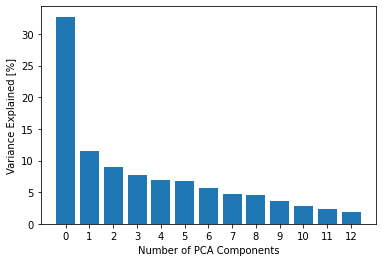

In [334]:
# refer to '15.4.3_3_Unsupervised Learning_Dimension reduction'
# refer to '15.6.3_Clustering Case Study - Customer Segmentation with K-Means - Tier 1'

# Create a PCA instance: pca
pca = PCA()

# Fit model to numeric features 
pca.fit(X_train_mean_scaled)

# Plot the explained variances
variance = pca.explained_variance_ratio_
plt.bar(range(len(variance)), variance*100)
plt.xlabel("Number of PCA Components")
plt.ylabel("Variance Explained [%]")
plt.xticks(range(len(variance)))
plt.show()

In [339]:
# Check how many pca components to include
variance[0:4].sum()*100, variance[0:5].sum()*100, variance[0:6].sum()*100,  variance[0:7].sum()*100

(60.935554621935516, 67.81847465735652, 74.58079729774343, 80.29816763153919)

Some criteria say that the total variance explained by all components should be between 70% to 80% variance. 
- reference: https://stats.idre.ucla.edu/spss/seminars/efa-spss/

I decided to pick 4 pca components below by eyeballing, which ended up only explained 60% of variance. In order to explain 70%-80% variance, I should have picked 6-7 pca components to fit the model.

**Eyeballed Decision**: It looks like PCA features 0 have the most significant variance (first elbow). Will keep PCA features 0 - 3 (2nd elbow) for more variance to be conservative.

In [212]:
# Create a PCA model with 4 components: pca
pca = PCA(n_components=4)

# Fit the PCA instance to the numeric features
pca.fit(X_train_mean_scaled)

# Transform the numeric features: pca_features
pca_X_train_mean_scaled = pca.transform(X_train_mean_scaled)

# Print the shape of pca_features
print(pca_X_train_mean_scaled.shape)
print(type(pca_X_train_mean_scaled))
pca_X_train_mean_scaled = pd.DataFrame(pca_X_train_mean_scaled, columns=['pca0','pca1','pca2','pca3'])
pca_X_train_mean_scaled.head()

(5012, 4)
<class 'numpy.ndarray'>


,pca0,pca1,pca2,pca3
0,-2.491191,-0.459051,1.182508,0.081856
1,-0.011536,1.268962,-0.139542,0.019501
2,-1.311341,-0.782541,-0.606125,-0.821669
3,0.022627,-0.192157,2.184337,0.431121
4,-0.386141,1.929972,-0.217576,0.681070


In [213]:
# Create a PCA model with 4 components: pca
pca = PCA(n_components=4)

# Fit the PCA instance to the numeric features
pca.fit(X_test_mean_scaled)

# Transform the numeric features: pca_features
pca_X_test_mean_scaled = pca.transform(X_test_mean_scaled)

# Print the shape of pca_features
print(pca_X_test_mean_scaled.shape)
print(type(pca_X_test_mean_scaled))
pca_X_test_mean_scaled = pd.DataFrame(pca_X_test_mean_scaled, columns=['pca0','pca1','pca2','pca3'])
pca_X_test_mean_scaled.head()

(1254, 4)
<class 'numpy.ndarray'>


,pca0,pca1,pca2,pca3
0,-0.772253,-1.415618,1.773742,-0.246612
1,-0.169652,-1.219467,1.250325,0.200359
2,-2.660008,0.149781,1.212009,-2.183676
3,0.138555,-0.730671,1.873763,-1.039202
4,1.213567,1.276207,1.131137,0.812500


In [214]:
# Combine pca scaled features + dummy variabls + the original binary features
# pca_X_train_mean_scaled + X_train1 + X_train2_mean['samerace']
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
# X_train_odmb = pd.merge(X_train1, X_train2_mean['samerace'], left_index=True, right_index=True) 
# print(X_train_odmb.shape)
pca_X_train_mean_scaled_odmb = pd.merge(pca_X_train_mean_scaled, X_train_odmb, left_index=True, right_index=True)
print(pca_X_train_mean_scaled_odmb.shape)
pca_X_train_mean_scaled_odmb.head() 

(5012, 229)


,pca0,pca1,pca2,pca3,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-2.491191,-0.459051,1.182508,0.081856,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,-0.011536,1.268962,-0.139542,0.019501,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,-1.311341,-0.782541,-0.606125,-0.821669,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,1,0
3,0.022627,-0.192157,2.184337,0.431121,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
4,-0.386141,1.929972,-0.217576,0.681070,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [215]:
# pca_X_test_mean_scaled + X_test1 + X_test2_mean['samerace']
#%%%% if using left_index and right_index to merge df, need to make sure the index are reset starting from 0.
# X_test_odmb = pd.merge(X_test1, X_test2_mean['samerace'], left_index=True, right_index=True)
# print(X_test_odmb.shape)
# X_train_odmb.head()
pca_X_test_mean_scaled_odmb = pd.merge(pca_X_test_mean_scaled, X_test_odmb, left_index=True, right_index=True)
print(pca_X_test_mean_scaled_odmb.shape)
pca_X_test_mean_scaled_odmb.head() 

(1254, 229)


,pca0,pca1,pca2,pca3,race_1.0,race_2.0,race_3.0,race_4.0,race_6.0,field_American Studies,...,met_o_1.0,met_o_2.0,met_o_3.0,met_o_5.0,met_o_6.0,met_o_7.0,met_o_8.0,gender,match,samerace
0,-0.772253,-1.415618,1.773742,-0.246612,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,-0.169652,-1.219467,1.250325,0.200359,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
2,-2.660008,0.149781,1.212009,-2.183676,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0.138555,-0.730671,1.873763,-1.039202,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,1.213567,1.276207,1.131137,0.812500,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3.5 Fit Model 

In [216]:
# check the balance of origianl data.
# https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data
y.sum()/len(y)*100

42.770507500797954

Since the proportion of minority class is 42%, the degree of imbalance for this dataset can be considered as mild. The default model fitting metric, 'accuracy',  should be avoided to evaluate imbalance dataset. Instead, 'log loss' metric is recommended for imblance dataset. For our dataset, the degree of imbalance is mild so 'accuracy' should be ok but we will use **'log loss'** to train the models.

### 3.5.1 LogisticRegression via sklearn

In [217]:
# make sure the y input for sklearn model is 1d array
y_train.shape, y_test.shape

((5012,), (1254,))

In [218]:
# check possible range for c_space
np.logspace(-5, 8, 15)

array([1.00000000e-05, 8.48342898e-05, 7.19685673e-04, 6.10540230e-03,
       5.17947468e-02, 4.39397056e-01, 3.72759372e+00, 3.16227766e+01,
       2.68269580e+02, 2.27584593e+03, 1.93069773e+04, 1.63789371e+05,
       1.38949549e+06, 1.17876863e+07, 1.00000000e+08])

#### 3.5.1.1 numeric features without PCA

Accuracy as training matric first to compare.

In [219]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg0 = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1, random_state=45) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
# https://datascience.stackexchange.com/questions/94261/whats-the-default-scorer-in-sci-kit-learns-gridsearchcv
logreg_cv0 = GridSearchCV(logreg0, param_grid, cv=5, n_jobs=-1)

# Fit it to the data
start_time = datetime.datetime.now() #%%%% need to put this right before
logreg_cv0.fit(X_train_mean_scaled_odmb, y_train)
lgsk_train_run_time0 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', lgsk_train_run_time0)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv0.best_params_)) 
print("Best score is {}".format(logreg_cv0.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best0 = logreg_cv0.best_estimator_
training_accuracy = logreg_best0.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best0.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
start_time = datetime.datetime.now() #%%%% need to put this right before
lg_y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb) #### depending on if we want higher precision or recall, we can add extra code here to bias our prediction to certatin ways.0.5
lgsk_run_time0 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', lgsk_run_time0)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, lg_y_pred0))
print(classification_report(y_test, lg_y_pred0))

training run time:  0:01:30.710812
Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is 0.8314085687050625
Accuracy on training data: 0.86
Accuracy on test data:     0.82
prediction run time:  0:00:00.006000
[[617  97]
 [128 412]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       714
           1       0.81      0.76      0.79       540

    accuracy                           0.82      1254
   macro avg       0.82      0.81      0.82      1254
weighted avg       0.82      0.82      0.82      1254

Wall time: 1min 30s


In [220]:
# check the data balance of prediction
540/(540+714)*100

43.0622009569378

Using accuracy as training metric, degree of imbalance in prediction is mild (43%).

Log loss as training matric.

In [221]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg0 = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1, random_state=45) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logreg_cv0 = GridSearchCV(logreg0, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
start_time = datetime.datetime.now() #%%%% need to put this right before
logreg_cv0.fit(X_train_mean_scaled_odmb, y_train)
lgsk_train_run_time0 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', lgsk_train_run_time0)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv0.best_params_)) 
print("Best score is {}".format(logreg_cv0.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best0 = logreg_cv0.best_estimator_
training_accuracy = logreg_best0.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best0.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
start_time = datetime.datetime.now() #%%%% need to put this right before
lg_y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb) #### depending on if we want higher precision or recall, we can add extra code here to bias our prediction to certatin ways.0.5
lgsk_run_time0 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', lgsk_run_time0)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, lg_y_pred0))
print(classification_report(y_test, lg_y_pred0))

training run time:  0:01:25.715784
Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is -0.38076489959393633
Accuracy on training data: 0.86
Accuracy on test data:     0.82
prediction run time:  0:00:00.007001
[[617  97]
 [128 412]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       714
           1       0.81      0.76      0.79       540

    accuracy                           0.82      1254
   macro avg       0.82      0.81      0.82      1254
weighted avg       0.82      0.82      0.82      1254

Wall time: 1min 25s


In [222]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
l1_space = np.arange(0,1,0.1)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 


# Instantiate a logistic regression classifier: logreg
logreg1 = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1, random_state=45)
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logreg_cv1 = GridSearchCV(logreg1, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
start_time = datetime.datetime.now() #%%%% need to put this right before
logreg_cv1.fit(X_train_mean_scaled_odmb, y_train)
lgsk_train_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', lgsk_train_run_time1)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv1.best_params_)) 
print("Best score is {}".format(logreg_cv1.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best1 = logreg_cv1.best_estimator_
training_accuracy = logreg_best1.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best1.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# Predict the labels of the test data: y_pred
start_time = datetime.datetime.now() #%%%% need to put this right before
lg_y_pred1 = logreg_best1.predict(X_test_mean_scaled_odmb)
lgsk_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', lgsk_run_time1)

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, lg_y_pred1))
print(classification_report(y_test, lg_y_pred1))

training run time:  0:47:36.883772
Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'l1_ratio': 0.2, 'penalty': 'elasticnet'}
Best score is -0.3499249445451534
Accuracy on training data: 0.86
Accuracy on test data:     0.83
prediction run time:  0:00:00.009003
[[635  79]
 [140 400]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       714
           1       0.84      0.74      0.79       540

    accuracy                           0.83      1254
   macro avg       0.83      0.82      0.82      1254
weighted avg       0.83      0.83      0.82      1254

Wall time: 47min 36s


#### 3.5.1.2 numeric features with PCA

In [223]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 2)
l1_space = np.arange(0,1,0.5)
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logreg_cv = GridSearchCV(logreg, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best2 = logreg_cv.best_estimator_
training_accuracy = logreg_best2.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best2.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
y_pred2 = logreg_best2.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Tuned Logistic Regression Parameters: {'C': 100000000.0, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}
Best score is -0.39470953301075085
Accuracy on training data: 0.85
Accuracy on test data:     0.81
[[608 106]
 [137 403]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       714
           1       0.79      0.75      0.77       540

    accuracy                           0.81      1254
   macro avg       0.80      0.80      0.80      1254
weighted avg       0.81      0.81      0.81      1254

Wall time: 1min 55s


In [224]:
%%time
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'

# logistic regresion w elastic penalty
# refer to '14.1.2_3_Supervised Learning_Tuning'

# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
l1_space = np.arange(0,1,0.1) #%%%%% should pick range around 0.5 for better training!!
param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(solver='saga', max_iter=10000, n_jobs=-1) 
#%%%%%% need to specify solver and max_inter (default setting does not work)
#%%%%% n_jobs=-1 to make the code run faster by running codes parallelly!?

# Instantiate the GridSearchCV object: logreg_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
logreg_cv = GridSearchCV(logreg, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
logreg_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
logreg_best3 = logreg_cv.best_estimator_
training_accuracy = logreg_best3.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = logreg_best3.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
y_pred3 = logreg_best3.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'l1_ratio': 0.0, 'penalty': 'elasticnet'}
Best score is -0.3683666965898901
Accuracy on training data: 0.84
Accuracy on test data:     0.81
[[625  89]
 [149 391]]
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       714
           1       0.81      0.72      0.77       540

    accuracy                           0.81      1254
   macro avg       0.81      0.80      0.80      1254
weighted avg       0.81      0.81      0.81      1254

Wall time: 47min 4s


### 3.5.2 LogisticRegression via statsmodels

#### 3.5.2.1 numeric features without PCA

Higher the Pseudo R-squ.score, the better the model is. Adding constant may improve the Pseudo R-squ.

In [225]:
%%time
# statsmodel w/ constant & penalty term
# refer to 'https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/'

# Create constants for X (X_train_mean_scaled_odmb, X_test_mean_scaled_odmb), so the model knows its bounds
X_train_mean_scaled_odmb_c = sm.add_constant(X_train_mean_scaled_odmb) #%%%%% can I add constant after splitting into X_train, X_test?
X_test_mean_scaled_odmb_c = sm.add_constant(X_test_mean_scaled_odmb)

# add a little noise to avoid 'LinAlgError: Singular matrix'
# refer to 'https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests'
X_train_mean_scaled_odmb_c_dirty = X_train_mean_scaled_odmb_c + 0.00001*np.random.rand(X_train_mean_scaled_odmb_c.shape[0], X_train_mean_scaled_odmb_c.shape[1])
X_test_mean_scaled_odmb_c_dirty = X_test_mean_scaled_odmb_c + 0.00001*np.random.rand(X_test_mean_scaled_odmb_c.shape[0], X_test_mean_scaled_odmb_c.shape[1])

# Fit it to the data
# refer to 'https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html'
start_time = datetime.datetime.now() #%%%% need to put this right before
log_reg1 = sm.Logit(y_train, X_train_mean_scaled_odmb_c_dirty).fit_regularized() # default method='l1' (l2 or elasticnet penalty not available)
lgsm_train_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', lgsm_train_run_time1)

# Predict the labels of the test data: y_pred
start_time = datetime.datetime.now() #%%%% need to put this right before
y_pred1 = log_reg1.predict(X_test_mean_scaled_odmb_c_dirty)
lgsm_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', lgsm_run_time1)

# check statsmodel prediction
# print(type(y_pred1))
# print(y_pred1)

# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
y_pred1_df = pd.DataFrame({'probability': y_pred1})
# print(y_pred1_df)

# hope to use list comprehension
# refer to 'https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/'
y_pred1_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred1_df.probability] 
#%%%% y_pred1_df.prediction = [list comprehenshion] did not work!
# print(y_pred1_df) 

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred1_df.prediction))
print(classification_report(y_test, y_pred1_df.prediction))
# refer to 'https://www.youtube.com/watch?v=Kdsp6soqA7o&ab_channel=StatQuestwithJoshStarmer' to interpret confusion matrix
# refer to 'https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics' to interpret classififation report

overflow encountered in exp


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.30681419461124565
            Iterations: 949
            Function evaluations: 950
            Gradient evaluations: 949
training run time:  0:02:29.631174
prediction run time:  0:00:00.004999
[[615  99]
 [129 411]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       714
           1       0.81      0.76      0.78       540

    accuracy                           0.82      1254
   macro avg       0.82      0.81      0.81      1254
weighted avg       0.82      0.82      0.82      1254

Wall time: 2min 29s


In [226]:
# printing the summary table 
print(log_reg1.summary()) 

                           Logit Regression Results                           
Dep. Variable:                  dec_o   No. Observations:                 5012
Model:                          Logit   Df Residuals:                     4773
Method:                           MLE   Df Model:                          238
Date:                Sat, 20 Nov 2021   Pseudo R-squ.:                  0.5504
Time:                        02:34:29   Log-Likelihood:                -1537.8
converged:                       True   LL-Null:                       -3420.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             -2.5667      1.395     -1.840      0.066

overflow encountered in exp


Overall scores are little lower than sklearn model but runs much faster (due to no crossvalidation available)

#### 3.5.2.2 numeric features with PCA

In [227]:
%%time
# statsmodel w/ constant & penalty term
# refer to 'https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/'

# Create constants for X (X_train_mean_scaled_odmb, X_test_mean_scaled_odmb), so the model knows its bounds
pca_X_train_mean_scaled_odmb_c = sm.add_constant(pca_X_train_mean_scaled_odmb) #%%%%% can I add constant after splitting into X_train, X_test?
pca_X_test_mean_scaled_odmb_c = sm.add_constant(pca_X_test_mean_scaled_odmb)

# add a little noise to avoid 'LinAlgError: Singular matrix'
# refer to 'https://stackoverflow.com/questions/44305456/why-am-i-getting-linalgerror-singular-matrix-from-grangercausalitytests'
pca_X_train_mean_scaled_odmb_c_dirty = pca_X_train_mean_scaled_odmb_c + 0.00001*np.random.rand(pca_X_train_mean_scaled_odmb_c.shape[0], pca_X_train_mean_scaled_odmb_c.shape[1])
pca_X_test_mean_scaled_odmb_c_dirty = pca_X_test_mean_scaled_odmb_c + 0.00001*np.random.rand(pca_X_test_mean_scaled_odmb_c.shape[0], pca_X_test_mean_scaled_odmb_c.shape[1])

# Fit it to the data
# refer to 'https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit_regularized.html'
log_reg2 = sm.Logit(y_train, pca_X_train_mean_scaled_odmb_c_dirty).fit_regularized() # default method='l1' (l2 or elasticnet penalty not available)

# Predict the labels of the test data: y_pred
y_pred2 = log_reg2.predict(pca_X_test_mean_scaled_odmb_c_dirty)
# print(type(y_pred2))
# print(y_pred2)

# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
y_pred2_df = pd.DataFrame({'probability': y_pred2})
# print(y_pred2_df)

# hope to use list comprehension
# refer to 'https://chrisalbon.com/python/data_wrangling/pandas_list_comprehension/'
y_pred2_df['prediction'] = [0 if row < 0.5 else 1 for row in y_pred2_df.probability] 
#%%%% y_pred2_df.prediction = [list comprehenshion] did not work!
# y_pred2_df 

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred2_df.prediction))
print(classification_report(y_test, y_pred2_df.prediction))
# refer to 'https://www.youtube.com/watch?v=Kdsp6soqA7o&ab_channel=StatQuestwithJoshStarmer' to interpret confusion matrix
# refer to 'https://www.youtube.com/watch?v=2osIZ-dSPGE&ab_channel=codebasics' to interpret classififation report

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3245094328809078
            Iterations: 595
            Function evaluations: 596
            Gradient evaluations: 595
[[607 107]
 [137 403]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       714
           1       0.79      0.75      0.77       540

    accuracy                           0.81      1254
   macro avg       0.80      0.80      0.80      1254
weighted avg       0.80      0.81      0.80      1254

Wall time: 1min 32s


In [228]:
# printing the summary table 
print(log_reg2.summary()) 

                           Logit Regression Results                           
Dep. Variable:                  dec_o   No. Observations:                 5012
Model:                          Logit   Df Residuals:                     4782
Method:                           MLE   Df Model:                          229
Date:                Sat, 20 Nov 2021   Pseudo R-squ.:                  0.5245
Time:                        02:36:01   Log-Likelihood:                -1626.4
converged:                       True   LL-Null:                       -3420.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                             -2.4587      1.337     -1.839      0.066

quasi-separation. In this case some parameters will not be identified.


Without PCA restulted in slightly better scores overall than with PCA with comparable running time. Will use numeric features without PCA for further analysis.

### 3.5.3 Random Forest via sklearn

#### 3.5.3.1 numeric features without PCA

In [229]:
%%time
# refer to '14.3.5_Case Study - Decision Trees - RR Diner Coffee'

# Optimize max_depth=n (3-10?) %%%% which parameter to optimize? n_estimators? (100-300) using GridSearch?
# Plug in appropriate max_depth and random_state parameters 
# refer to 'https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html'
rfc = RandomForestClassifier(criterion='gini', max_depth=3, random_state = 1234) #%%%%% from previous best model!??

# Model and fit
rfc.fit(X_train_mean_scaled_odmb, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred 
y_pred = rfc.predict(X_test_mean_scaled_odmb)

# compute accuracy of train set and test set
training_accuracy = rfc.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy on training data: 0.80
Accuracy on test data:     0.77
[[639  75]
 [216 324]]
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       714
           1       0.81      0.60      0.69       540

    accuracy                           0.77      1254
   macro avg       0.78      0.75      0.75      1254
weighted avg       0.78      0.77      0.76      1254

Wall time: 546 ms


In [230]:
%%time
# start with small number of trees (n_estimators = [ 50, 100, 150, 200])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'

# Setup the hyperparameter grid
n_estimators = np.arange(50,250,50) # array([ 50, 100, 150, 200])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
rfc_cv = GridSearchCV(rfc, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
rfc_cv.fit(X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best = rfc_cv.best_estimator_
training_accuracy = rfc_best.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
y_pred = rfc_best.predict(X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}
Best score is -0.4500230480614199
Accuracy on training data: 0.85
Accuracy on test data:     0.80
[[620  94]
 [151 389]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       714
           1       0.81      0.72      0.76       540

    accuracy                           0.80      1254
   macro avg       0.80      0.79      0.80      1254
weighted avg       0.80      0.80      0.80      1254

Wall time: 1min 20s


Efficient model: running time within 10min! since 200 trees was the best, will increase the tree number.

In [231]:
%%time
# Increase the number of trees (n_estimators = [200, 300, 400, 500])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'

# Setup the hyperparameter grid
n_estimators = np.arange(200,600,100) # array([200, 300, 400, 500])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc0 = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
rfc_cv0 = GridSearchCV(rfc0, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
start_time = datetime.datetime.now() #%%%% need to put this right before
rfc_cv0.fit(X_train_mean_scaled_odmb, y_train)
rfc_train_run_time0 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', rfc_train_run_time0)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv0.best_params_)) 
print("Best score is {}".format(rfc_cv0.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best0 = rfc_cv0.best_estimator_
training_accuracy = rfc_best0.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best0.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
start_time = datetime.datetime.now() #%%%% need to put this right before
rfc_y_pred0 = rfc_best0.predict(X_test_mean_scaled_odmb)
rfc_run_time0 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', rfc_run_time0)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred0))
print(classification_report(y_test, rfc_y_pred0))

training run time:  0:04:00.713183
Tuned Logistic Regression Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Best score is -0.44885410287099486
Accuracy on training data: 0.85
Accuracy on test data:     0.81
prediction run time:  0:00:00.099005
[[627  87]
 [152 388]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       714
           1       0.82      0.72      0.76       540

    accuracy                           0.81      1254
   macro avg       0.81      0.80      0.80      1254
weighted avg       0.81      0.81      0.81      1254

Wall time: 4min 1s


Since 500 trees was the best, will increase the tree number.

In [232]:
%%time
# Increase the number of trees (n_estimators = [ 500,  600,  700,  800,  900, 1000])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'

# Setup the hyperparameter grid
n_estimators = np.arange(500,1100,100) # array([ 500,  600,  700,  800,  900, 1000])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc1 = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
rfc_cv1 = GridSearchCV(rfc1, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
start_time = datetime.datetime.now() #%%%% need to put this right before
rfc_cv1.fit(X_train_mean_scaled_odmb, y_train)
rfc_train_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('training run time: ', rfc_train_run_time1)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv1.best_params_)) 
print("Best score is {}".format(rfc_cv1.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best1 = rfc_cv.best_estimator_
training_accuracy = rfc_best1.score(X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best1.score(X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
start_time = datetime.datetime.now() #%%%% need to put this right before
rfc_y_pred1 = rfc_best1.predict(X_test_mean_scaled_odmb)
rfc_run_time1 = datetime.datetime.now() - start_time #%%%%% need to put this right after the code want to meature the time
print('prediction run time: ', rfc_run_time1)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred1))
print(classification_report(y_test, rfc_y_pred1))

training run time:  0:12:37.477749
Tuned Logistic Regression Parameters: {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 600}
Best score is -0.44826546517942223
Accuracy on training data: 0.85
Accuracy on test data:     0.80
prediction run time:  0:00:00.045004
[[620  94]
 [151 389]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       714
           1       0.81      0.72      0.76       540

    accuracy                           0.80      1254
   macro avg       0.80      0.79      0.80      1254
weighted avg       0.80      0.80      0.80      1254

Wall time: 12min 37s


#### 3.5.3.1 numeric features with PCA

In [233]:
%%time
# Start with the large number of trees (n_estimators = [ 500,  600,  700,  800,  900, 1000])

# refer to 'https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv'

# Setup the hyperparameter grid
n_estimators = np.arange(500,1100,100) # array([ 500,  600,  700,  800,  900, 1000])
max_depth = np.arange(3,9,1) # array([3, 4, 5, 6, 7, 8])
param_grid = { 
    'n_estimators': n_estimators,
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : max_depth,
    'criterion' :['gini', 'entropy']
}

# Instantiate a Random Forest Classifier: rfc
rfc = RandomForestClassifier(random_state = 1234)

# Instantiate the GridSearchCV object: rfc_cv
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
rfc_cv = GridSearchCV(rfc, param_grid, scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit it to the data
rfc_cv.fit(pca_X_train_mean_scaled_odmb, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(rfc_cv.best_params_)) 
print("Best score is {}".format(rfc_cv.best_score_))

# apply best estimators to test set
# refer to '14.2.11 Logistic Regression Advanced Case Study_mk'
rfc_best2 = rfc_cv.best_estimator_
training_accuracy = rfc_best2.score(pca_X_train_mean_scaled_odmb, y_train)
test_accuracy = rfc_best2.score(pca_X_test_mean_scaled_odmb, y_test)
print("Accuracy on training data: {:0.2f}".format(training_accuracy))
print("Accuracy on test data:     {:0.2f}".format(test_accuracy))

# other way to check the data: confusion
# refer to '14.1.2_3_SupervisedLearning_Tuning'

# Predict the labels of the test data: y_pred
rfc_y_pred2 = rfc_best2.predict(pca_X_test_mean_scaled_odmb)

# Compute and print the confusion matrix and classification report
print(confusion_matrix(y_test, rfc_y_pred2))
print(classification_report(y_test, rfc_y_pred2))

Tuned Logistic Regression Parameters: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Best score is -0.5048858484308361
Accuracy on training data: 0.81
Accuracy on test data:     0.79
[[676  38]
 [228 312]]
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       714
           1       0.89      0.58      0.70       540

    accuracy                           0.79      1254
   macro avg       0.82      0.76      0.77      1254
weighted avg       0.81      0.79      0.78      1254

Wall time: 13min


numeric features with PCA gave noticeably lower overall scores than numeric features without PCA. Since running time is about the same, will use numeric features without PCA for further analysis.

## 3.6 Feature importance analysis

### 3.6.1 LogisticRegression via sklearn using shap

In [234]:
# refer to 'https://github.com/slundberg/shap'
# install shap
# conda install -c conda-forge shap # this this code in Anaconda prompt(anaconda3)

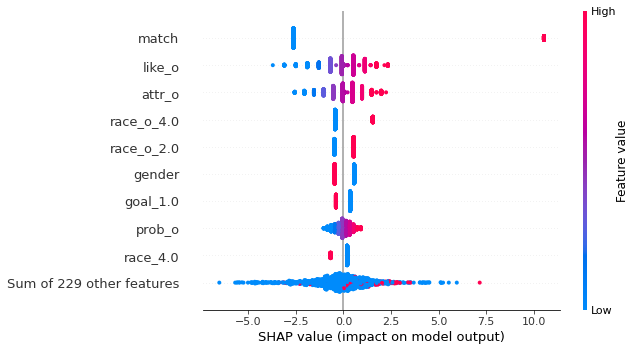

Wall time: 996 ms


In [345]:
%%time
# refer to 'https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.ipynb'

# Explain the linear model
logreg_explainer0 = shap.Explainer(logreg_best0, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns)
logreg_shap_values0_1 = logreg_explainer0(X_test_mean_scaled_odmb)

# Summarize the effect of all the features
shap.plots.beeswarm(logreg_shap_values0_1)

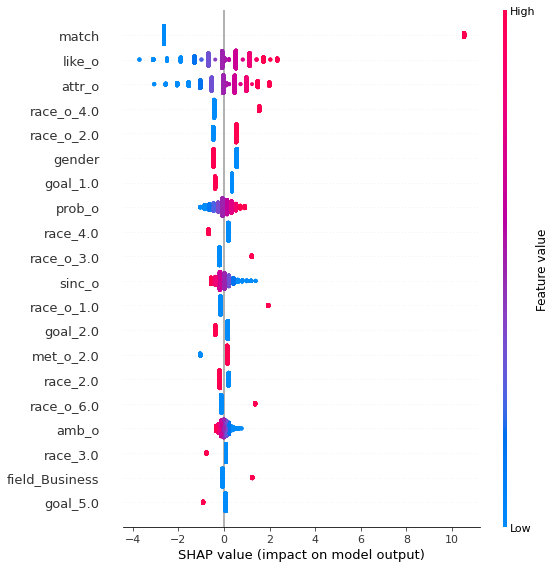

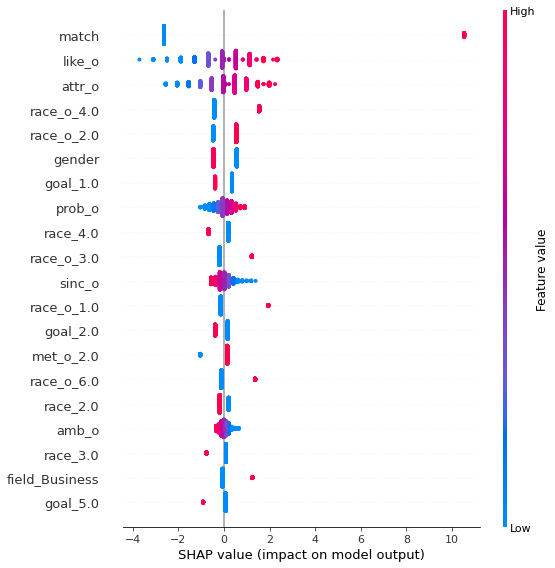

Wall time: 2.6 s


In [346]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'

# SHAP summary plot on training data
logreg_explainer0 = shap.Explainer(logreg_best0, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns) # same as above
logreg_shap_values0_2 = logreg_explainer0.shap_values(X_train_mean_scaled_odmb)
shap.summary_plot(logreg_shap_values0_2, X_train_mean_scaled_odmb)

# SHAP summary plot on test data
logreg_shap_values0_3 = logreg_explainer0.shap_values(X_test_mean_scaled_odmb)
shap.summary_plot(logreg_shap_values0_3, X_test_mean_scaled_odmb)

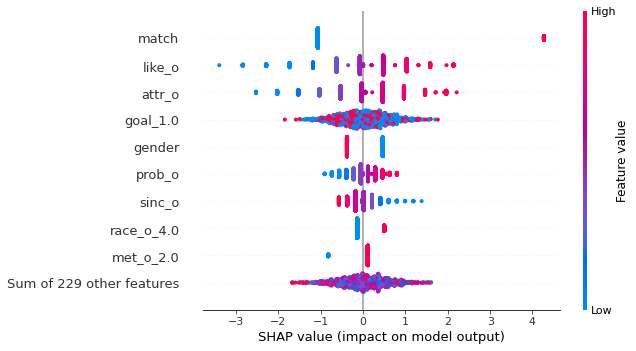

Wall time: 935 ms


In [342]:
%%time
# refer to 'https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/linear_models/Sentiment%20Analysis%20with%20Logistic%20Regression.ipynb'

# Explain the linear model
logreg_explainer1 = shap.Explainer(logreg_best1, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns)
logreg_shap_values1_1 = logreg_explainer1(X_test_mean_scaled_odmb)

# Summarize the effect of all the features
shap.plots.beeswarm(logreg_shap_values1_1)

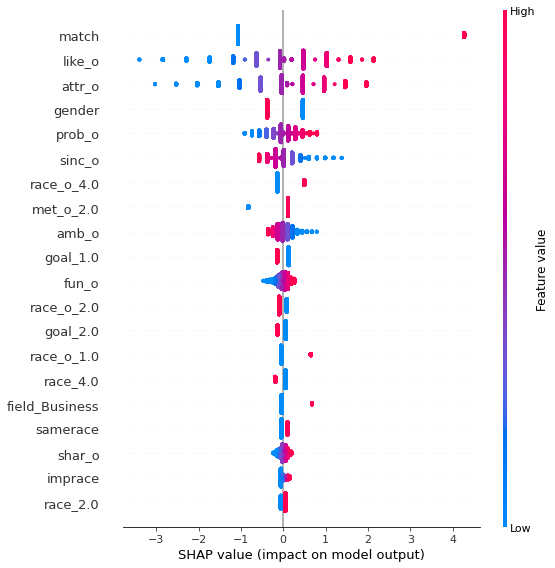

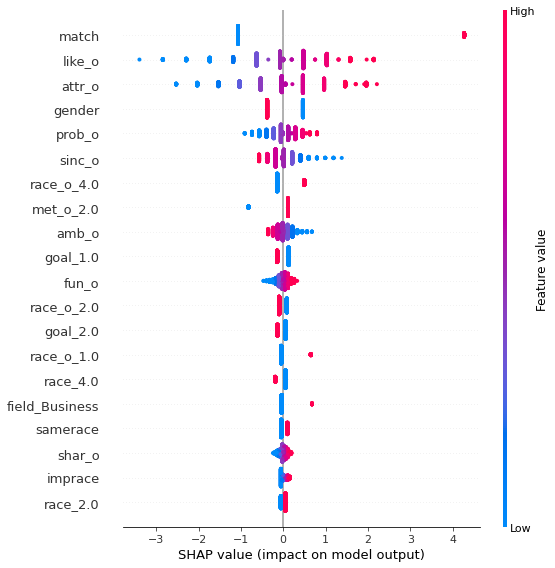

Wall time: 2.67 s


In [344]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'

# SHAP summary plot on training data
logreg_explainer1 = shap.Explainer(logreg_best1, X_train_mean_scaled_odmb, feature_names=X_train_mean_scaled_odmb.columns) # same as above
logreg_shap_values1_2 = logreg_explainer1.shap_values(X_train_mean_scaled_odmb)
shap.summary_plot(logreg_shap_values1_2, X_train_mean_scaled_odmb)

# SHAP summary plot on test data
logreg_shap_values1_3 = logreg_explainer1.shap_values(X_test_mean_scaled_odmb)
shap.summary_plot(logreg_shap_values1_3, X_test_mean_scaled_odmb)

**shap plot interpretation**
- Feature importance: Variables are ranked in descending order.
- Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.
- Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.
- Correlation: The “high” comes from the red color, and the “positive” impact is shown on the X-axis.

Refererence: 'https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a'

sklearn logistic regression model (both genders):
- top 20 important features are the same between train set and test set with slight difference in order
- positive correlation: match, like_o, attr_o, prob_o, met_o_2.0, race_o_4.0, race_2.0, fun_o, shar_o, race_o_1.0, fild_Business, samerace, imprace, int_corr
    - like_o, attr_o, fun_o, shar_o, prob_o: the higher the partner rate the subject in how much they like the subject, how much they think the subject like them, attractiveness, shared interest, and fun, the pertner will want to date the subject. 
    -  int_corr: the partner tend to want to date the subject with higher the correlation between subject’s and partner’s ratings of interests.
    - met_o_2.0: the pertner tend to want to date the subject whom they have never met.
    - race_o_4.0: Asian/Pacific Islander/Asian-American partner tend give more yes decision to date the subject.
    - race_2.0: European/Caucasian-American subject is popular and likely to get more yes decision to date from a partner.
    - race_o_1.0: Black/African American partner tend give more yes decision to date the subject.
    - fild_Business: peopole majoring Business is popular and likely to get more yes decision to date from a partner.
    - samerace: partner tend give more yes decision to date the subject with same race.
    - imprace: the partner who cares more about dating a subject with the same race tend to give more yes decision to date the subject.
- negarive correlation: gender, sinc_o, rece_o_2.0, amb_o, goal_1.0, goal_2.0.
    - gender: subject gender (0=female, 1=male) is opposite of the partner gender, meaning female partner tend to give more no decision to date the subject while male parner tend to give more yest decision to date the subject.

### 3.6.2 LogisticRegression via statsmodel

In [237]:
%%time
# use statsmodels.discrete.discrete_model.LogitResults.get_margeff!?
results_summary = log_reg1.get_margeff().summary() # this is the logodd ratio
results_summary
# freature_importance_smLogReg_df = pd.DataFrame(log_reg1.get_margeff().summary()) this gives 'ValueError: DataFrame constructor not properly called!'
# how to extract the info 
# X_train_mean_scaled = pd.DataFrame(X_train_mean_scaled, columns=X_train3_mean.columns)

overflow encountered in exp
overflow encountered in square
invalid value encountered in true_divide
invalid value encountered in square


Wall time: 6.56 s


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  dec_o
Method:                          dydx
At:                           overall
==================================================================================================================================
                                                                    dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
const                                                                 nan        nan        nan        nan         nan         nan
age                                                                   nan        nan        nan        nan         nan         nan
int_corr                                                              nan        nan        nan        nan         nan         nan
imprace                                                               nan        nan        nan        nan         nan         nan
imprelig                                                              nan        nan        nan        nan         nan         nan
age_o                                                                 nan        nan        nan        nan         nan         nan
attr_o                                                                nan        nan        nan        nan         nan         nan
sinc_o                                                                nan        nan        nan        nan         nan         nan
intel_o                                                               nan        nan        nan        nan         nan         nan
fun_o                                                                 nan        nan        nan        nan         nan         nan
amb_o                                                                 nan        nan        nan        nan         nan         nan
shar_o                                                                nan        nan        nan        nan         nan         nan
like_o                                                                nan        nan        nan        nan         nan         nan
prob_o                                                                nan        nan        nan        nan         nan         nan
race_1.0                                                              nan        nan        nan        nan         nan         nan
race_2.0                                                              nan        nan        nan        nan         nan         nan
race_3.0                                                              nan        nan        nan        nan         nan         nan
race_4.0                                                              nan        nan        nan        nan         nan         nan
race_6.0                                                              nan        nan        nan        nan         nan         nan
field_American Studies                                                nan        nan        nan        nan         nan         nan
field_American Studies (Masters)                                      nan        nan        nan        nan         nan         nan
field_Anthropology                                                    nan        nan        nan        nan         nan         nan
field_Applied Maths/Econs                                             nan        nan        nan        nan         nan         nan
field_Applied Physiology & Nutrition                                  nan        nan        nan        nan         nan         nan
field_Architecture                                                    nan        nan        nan        nan         nan         nan
field_Art Education                                                   nan        nan        na

In [238]:
# convert statsmodel summary table to df
# refer to 'https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe'
# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
results_as_html = results_summary.tables[1].as_html()
results_summary_df = pd.read_html(results_as_html, header=0, index_col=0)[0]
results_summary_df

,dy/dx,std err,z,P>|z|,[0.025,0.975]
const,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,NaN,NaN,NaN,NaN,NaN
int_corr,NaN,NaN,NaN,NaN,NaN,NaN
imprace,NaN,NaN,NaN,NaN,NaN,NaN
imprelig,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
met_o_7.0,NaN,NaN,NaN,NaN,NaN,NaN
met_o_8.0,NaN,NaN,NaN,NaN,NaN,NaN
gender,NaN,NaN,NaN,NaN,NaN,NaN
match,NaN,NaN,NaN,NaN,NaN,NaN


In [239]:
# sort by dy/dx
# refer to 'https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html'
results_summary_df.sort_values(by='dy/dx', ascending=False)

,dy/dx,std err,z,P>|z|,[0.025,0.975]
const,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,NaN,NaN,NaN,NaN,NaN
int_corr,NaN,NaN,NaN,NaN,NaN,NaN
imprace,NaN,NaN,NaN,NaN,NaN,NaN
imprelig,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
met_o_7.0,NaN,NaN,NaN,NaN,NaN,NaN
met_o_8.0,NaN,NaN,NaN,NaN,NaN,NaN
gender,NaN,NaN,NaN,NaN,NaN,NaN
match,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
# to show all rows in df
# refer to 'https://dev.to/chanduthedev/how-to-display-all-rows-from-data-frame-using-pandas-dha'
pd.set_option('display.max_rows', results_summary_df.shape[0]+1)
results_summary_df.sort_values(by='dy/dx', ascending=False)

,dy/dx,std err,z,P>|z|,[0.025,0.975]
const,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,NaN,NaN,NaN,NaN,NaN
int_corr,NaN,NaN,NaN,NaN,NaN,NaN
imprace,NaN,NaN,NaN,NaN,NaN,NaN
imprelig,NaN,NaN,NaN,NaN,NaN,NaN
age_o,NaN,NaN,NaN,NaN,NaN,NaN
attr_o,NaN,NaN,NaN,NaN,NaN,NaN
sinc_o,NaN,NaN,NaN,NaN,NaN,NaN
intel_o,NaN,NaN,NaN,NaN,NaN,NaN
fun_o,NaN,NaN,NaN,NaN,NaN,NaN


In [241]:
# to show atop 20 rows in df 
results_summary_df.sort_values(by='dy/dx', ascending=False).head(20)

,dy/dx,std err,z,P>|z|,[0.025,0.975]
const,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,NaN,NaN,NaN,NaN,NaN
int_corr,NaN,NaN,NaN,NaN,NaN,NaN
imprace,NaN,NaN,NaN,NaN,NaN,NaN
imprelig,NaN,NaN,NaN,NaN,NaN,NaN
age_o,NaN,NaN,NaN,NaN,NaN,NaN
attr_o,NaN,NaN,NaN,NaN,NaN,NaN
sinc_o,NaN,NaN,NaN,NaN,NaN,NaN
intel_o,NaN,NaN,NaN,NaN,NaN,NaN
fun_o,NaN,NaN,NaN,NaN,NaN,NaN


In [242]:
# sort by'P>|z|'
# to show atop 20 rows in df 
results_summary_df.sort_values(by='P>|z|').head(20) 
# shoudl compare this table with original summary table to see if P>|z| changed...!?

,dy/dx,std err,z,P>|z|,[0.025,0.975]
const,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,NaN,NaN,NaN,NaN,NaN
int_corr,NaN,NaN,NaN,NaN,NaN,NaN
imprace,NaN,NaN,NaN,NaN,NaN,NaN
imprelig,NaN,NaN,NaN,NaN,NaN,NaN
age_o,NaN,NaN,NaN,NaN,NaN,NaN
attr_o,NaN,NaN,NaN,NaN,NaN,NaN
sinc_o,NaN,NaN,NaN,NaN,NaN,NaN
intel_o,NaN,NaN,NaN,NaN,NaN,NaN
fun_o,NaN,NaN,NaN,NaN,NaN,NaN


In [243]:
# to show atop 20 rows in df choose significant, 
results_summary_df[results_summary_df['P>|z|'] < 0.05].sort_values(by='dy/dx', ascending=False).head(20)

,dy/dx,std err,z,P>|z|,[0.025,0.975]


**'statsmodels.discrete.discrete_model.LogitResults.get_margeff' interpretation**
- Practical feature importance: log odd marginal effect (dy/dx)
    - The larger the value, the more significant.
- Statistical feature importance: p-value (P>|z|)
    - The smaller the value, the more significant.
- Correlation (z?)
    - z > 0: positive correlation with target dec_o variable (the larger the feature value, desicion = 1, yes to date)
    - z < 0: negative correlation with target dec_o variable (the larger the feature value, desicion = 0, no to date)

### 3.6.3 Random Forest via sklearn

#### 3.6.3.1 Using shap

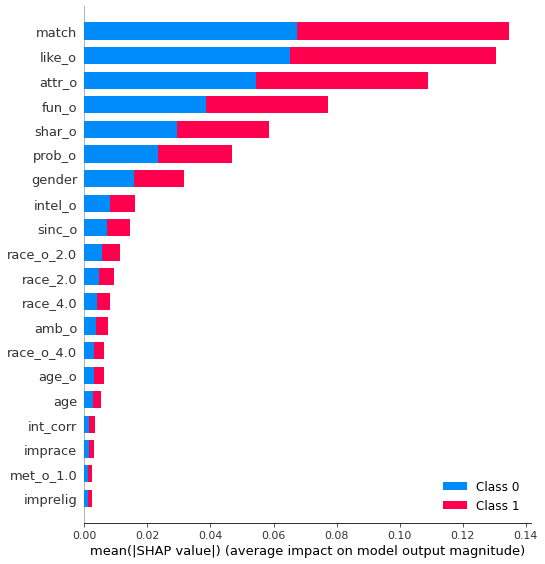

Wall time: 19.9 s


In [244]:
%%time
# refer to 'https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.ipynb'

# Explain the linear model
rfc_explainer1 = shap.TreeExplainer(rfc_best1, feature_names=X_train_mean_scaled_odmb.columns)
rfc_shap_values1 = rfc_explainer1.shap_values(X_train_mean_scaled_odmb) # this shap value is 'list' object with no

# Summarize the effect of all the features
shap.summary_plot(rfc_shap_values1, X_test_mean_scaled_odmb)

In [245]:
# check size of rfc_y_pred1
rfc_y_pred1 # need to convert this to list with 2 element.

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)

In [246]:
# to count the 0 and 1 in y_pred1_rfc
# refer to 'https://stackoverflow.com/questions/28663856/how-to-count-the-occurrence-of-certain-item-in-an-ndarray'
collections.Counter(rfc_y_pred1)

Counter({0: 771, 1: 483})

In [247]:
# ideally this value should be 0 to make symmetry plot above!?
print(np.abs([np.sum(list(rfc_shap_values1[0])), np.sum(list(rfc_shap_values1[1]))] + rfc_explainer1.expected_value - [780, 474]).max()) 
#%%%% original code was rcf_shap_values.sum(1), but rcf_shap_values is list object that does not have sum attribute.
# np.abs(shap_values.sum(1) + explainer.expected_value - pred).max() > this output should be 0 to get symmetry plot.

778.825757082228


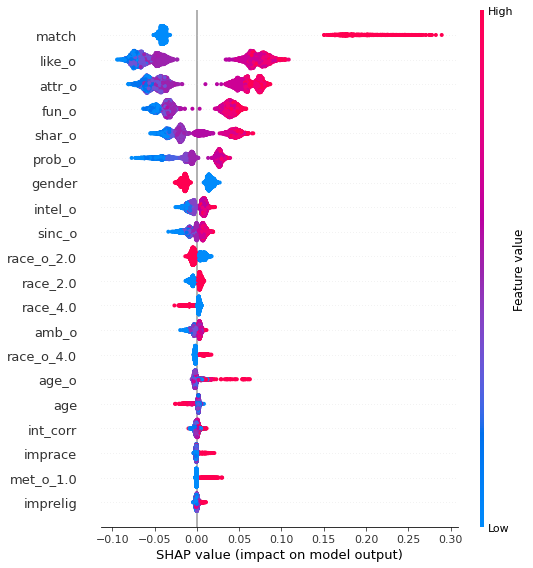

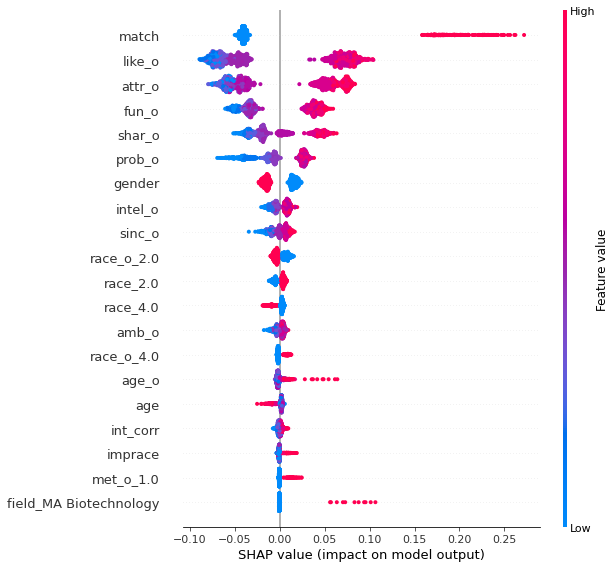

Wall time: 27.5 s


In [248]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'

# SHAP summary plot on training data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values2 = rfc_explainer1.shap_values(X_train_mean_scaled_odmb, approximate=False, check_additivity=False)
shap.summary_plot(rfc_shap_values2[1], X_train_mean_scaled_odmb)

# SHAP summary plot on test data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values3 = rfc_explainer1.shap_values(X_test_mean_scaled_odmb, approximate=False, check_additivity=False)
shap.summary_plot(rfc_shap_values3[1], X_test_mean_scaled_odmb)

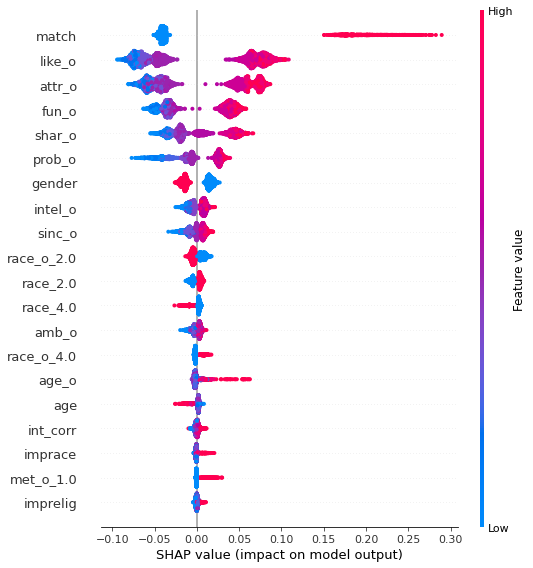

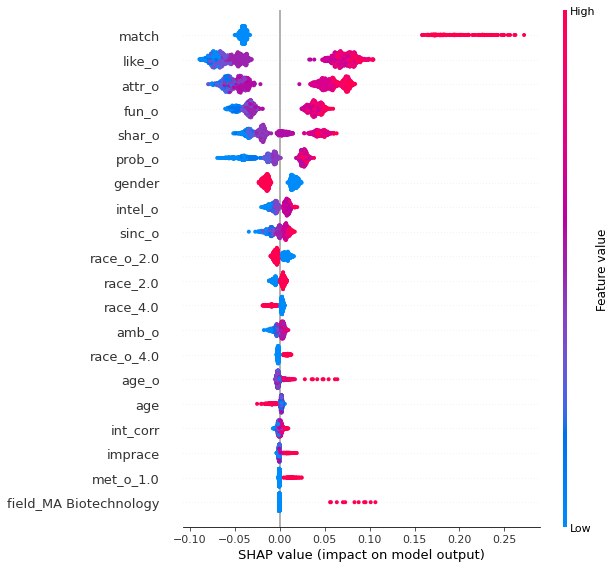

Wall time: 25.8 s


In [249]:
%%time 
# refer to 'https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9'

# SHAP summary plot on training data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values2a = rfc_explainer1.shap_values(X_train_mean_scaled_odmb)
shap.summary_plot(rfc_shap_values2a[1], X_train_mean_scaled_odmb)

# SHAP summary plot on test data
#explainer = shap.TreeExplainer(rfc_best1)
rfc_shap_values3a = rfc_explainer1.shap_values(X_test_mean_scaled_odmb)
shap.summary_plot(rfc_shap_values3a[1], X_test_mean_scaled_odmb)

#### 3.6.3.2 Using Sklearn Tree model attribute: feature_importances_ 

30


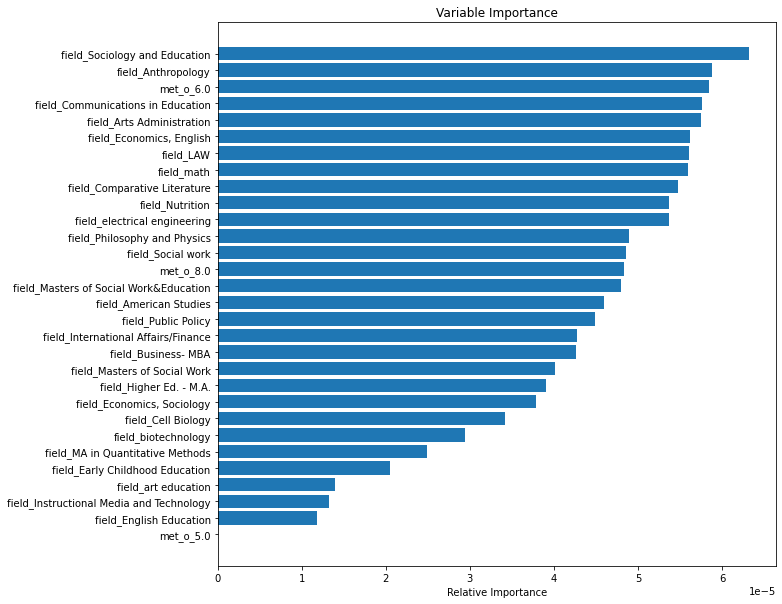

In [250]:
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[:30]
sorted_idx = np.argsort(feature_importance_rfc)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


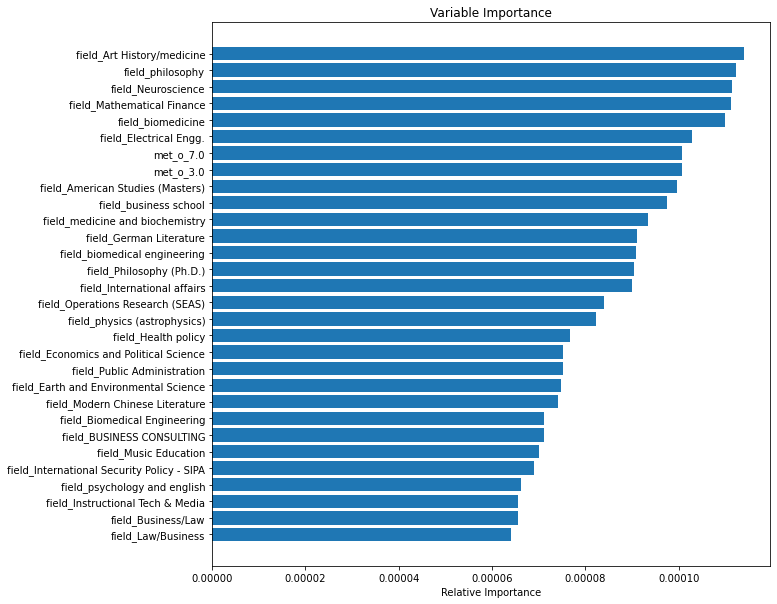

In [251]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[30:60]
sorted_idx = np.argsort(feature_importance_rfc)[30:60]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


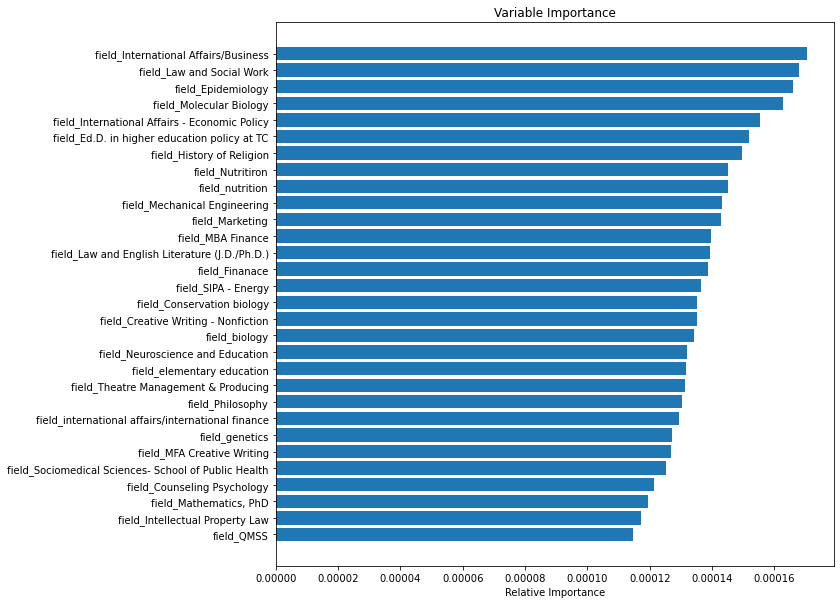

In [252]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[60:90]
sorted_idx = np.argsort(feature_importance_rfc)[60:90]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


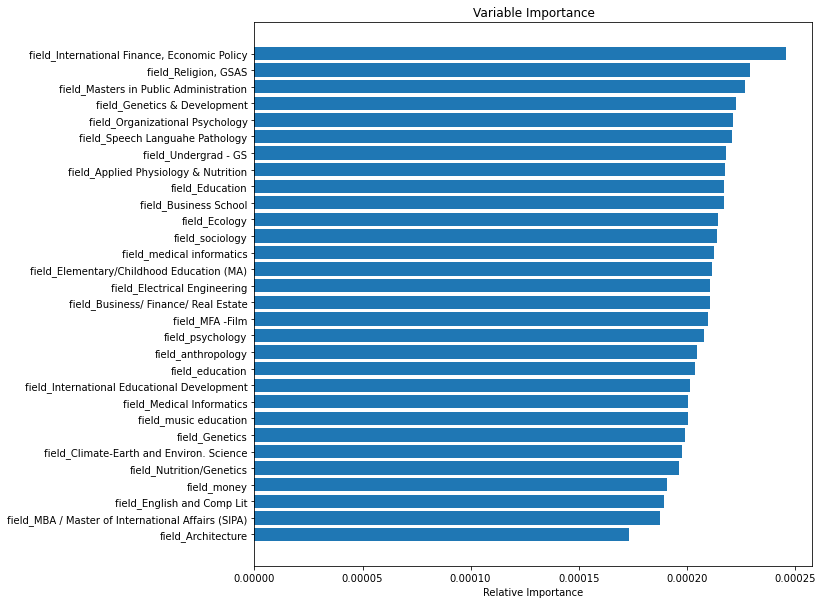

In [253]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[90:120]
sorted_idx = np.argsort(feature_importance_rfc)[90:120]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


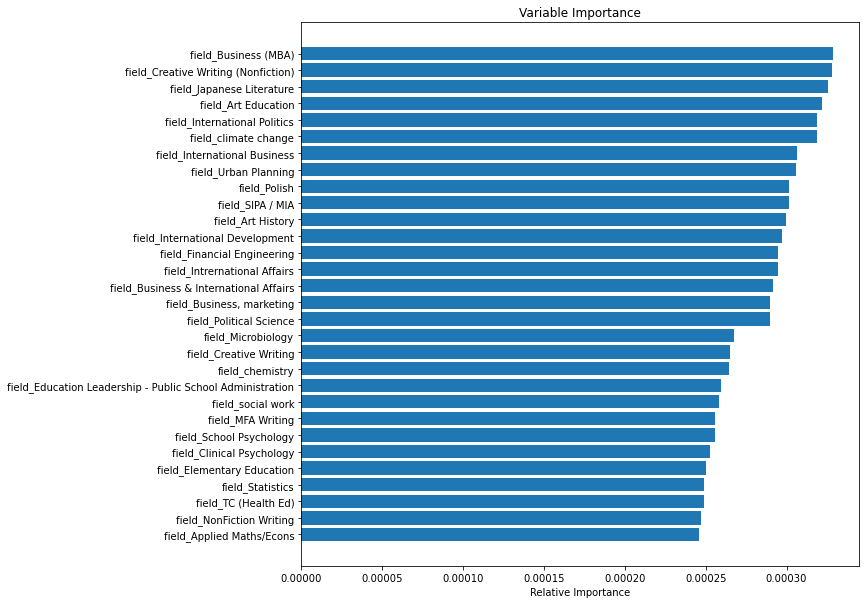

In [254]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[120:150]
sorted_idx = np.argsort(feature_importance_rfc)[120:150]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


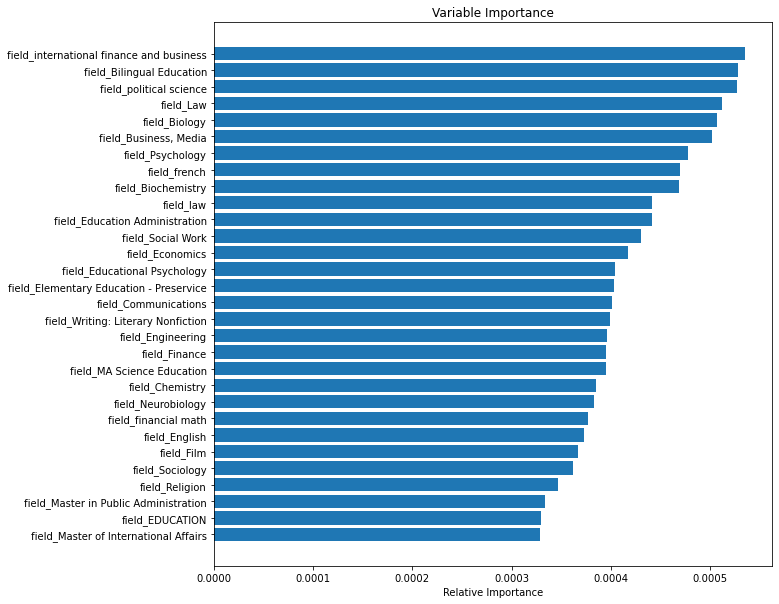

In [255]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[150:180]
sorted_idx = np.argsort(feature_importance_rfc)[150:180]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

30


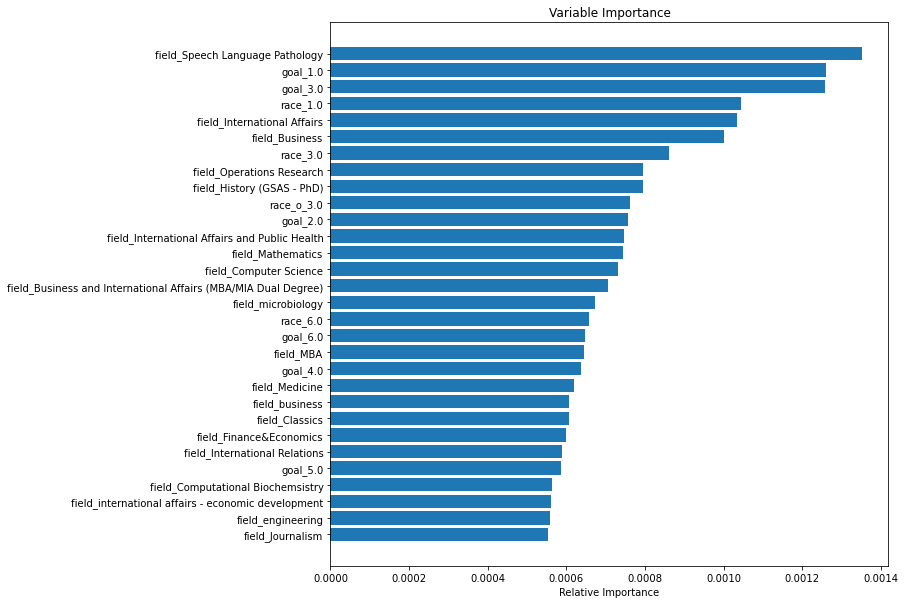

In [256]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[180:210]
sorted_idx = np.argsort(feature_importance_rfc)[180:210]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

28


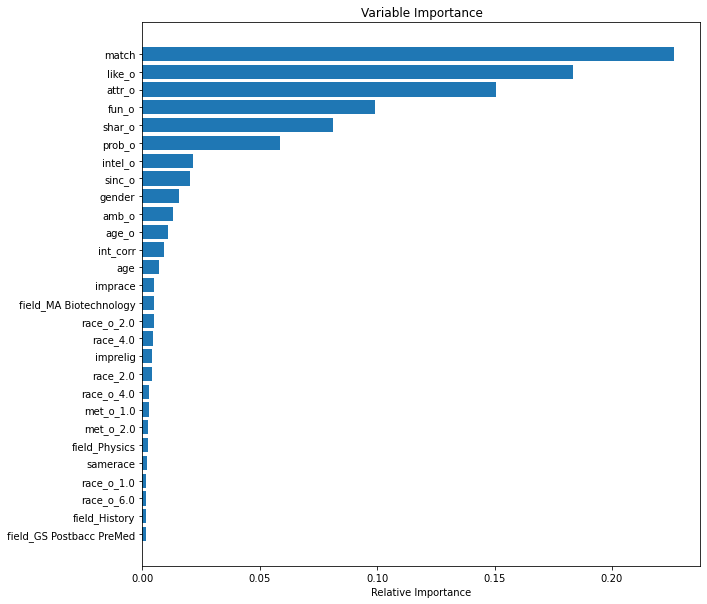

In [257]:
# want to see the importance of attributes...
# refer to '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
feature_importance_rfc = rfc_best1.feature_importances_  #%%%%%% change this to logreg_best1 later
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance_rfc / feature_importance_rfc.max())[210:240]
sorted_idx = np.argsort(feature_importance_rfc)[210:240]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_rfc[sorted_idx], align='center')
plt.yticks(pos, X_train_mean_scaled_odmb.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [258]:
# refer to 'https://ff06-2020.fastforwardlabs.com/'
# to interpret resutls. 

## 3.7 Model Evalution

Compare the pre-selected model from logistic regression via skelarn and statsmodel and Random Forest via sklearn in terms of evaluation metrics (classification report), computational complexity (runnig time), and scalability & maintenance costs (model sizse).

### 3.7.1 Classification Report, Run time, and Size of each Model

In [259]:
# convert Scikit Learn Classification Report to Dataframe
# refer to 'https://gist.github.com/fclesio/bb5871281debc07d75127552c56b08b5'
def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    #df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report

In [260]:
# to measure model size
# refer to 'https://www.kite.com/python/docs/sys.getsizeof'
lgsk_size0 = sys.getsizeof(pickle.dumps(logreg_cv0)) #%%%% Return the size of an object in bytes
lgsk_size1 = sys.getsizeof(pickle.dumps(logreg_cv1))
lgsm_size1 = sys.getsizeof(pickle.dumps(log_reg1))  
rfc_size0 = sys.getsizeof(pickle.dumps(rfc_cv0)) #%%%%%% rfc should have larger size than lg. 
rfc_size1 = sys.getsizeof(pickle.dumps(rfc_cv1))
#%%%% print(sys.getsizeof(X)) is not the right way to calculate the accurate size because all gave '48' as output
#%%%% rfc should have larger size than lg. 
#%%%% X = logreg0, logreg1, rfc0, rfc1, logreg_cv0, logreg_cv1, rfc_cv0, rfc_cv1


#### 3.7.1.1 logistic regreassion via sklearn

In [261]:
# logistic regreassion via sklearn 1
print('training run time: ', lgsk_train_run_time0)
print('prediction run time: ', lgsk_run_time0)
print('model size: ', lgsk_size0)
lgsk_report0_df =  get_classification_report(y_test, lg_y_pred0)
lgsk_report0_df

training run time:  0:01:25.715784
prediction run time:  0:00:00.007001
model size:  4835


,precision,recall,f1-score,support
0,0.828188,0.864146,0.845785,714.000000
1,0.809430,0.762963,0.785510,540.000000
accuracy,0.820574,0.820574,0.820574,0.820574
macro avg,0.818809,0.813554,0.815647,1254.000000
weighted avg,0.820110,0.820574,0.819829,1254.000000


In [262]:
# logistic regreassion via sklearn 2
print('training run time: ', lgsk_train_run_time1)
print('prediction run time: ', lgsk_run_time1)
print('model size: ', lgsk_size1)
lgsk_report1_df  =  get_classification_report(y_test, lg_y_pred1)
lgsk_report1_df 

training run time:  0:47:36.883772
prediction run time:  0:00:00.009003
model size:  23000


,precision,recall,f1-score,support
0,0.819355,0.889356,0.852921,714.000000
1,0.835073,0.740741,0.785083,540.000000
accuracy,0.825359,0.825359,0.825359,0.825359
macro avg,0.827214,0.815048,0.819002,1254.000000
weighted avg,0.826123,0.825359,0.823709,1254.000000


#### 3.7.1.2 logistic regreassion via statsmodel

In [263]:
# logistic regreassion via statsmodel
print('training run time: ', lgsm_train_run_time1)
print('prediction run time: ', lgsm_run_time1)
print('model size: ', lgsm_size1)
lgsm_report1_df =  get_classification_report(y_test, y_pred1_df.prediction)
lgsm_report1_df

training run time:  0:02:29.631174
prediction run time:  0:00:00.004999
model size:  19722725


,precision,recall,f1-score,support
0,0.826613,0.861345,0.843621,714.000000
1,0.805882,0.761111,0.782857,540.000000
accuracy,0.818182,0.818182,0.818182,0.818182
macro avg,0.816248,0.811228,0.813239,1254.000000
weighted avg,0.817686,0.818182,0.817455,1254.000000


#### 3.7.1.3 Random forest model via sklearn

In [264]:
# Random forest model 1
print('training run time: ', rfc_train_run_time0)
print('prediction run time: ', rfc_run_time0)
print('model size: ', rfc_size0)
rfc_report0_df =  get_classification_report(y_test, rfc_y_pred0)
rfc_report0_df

training run time:  0:04:00.713183
prediction run time:  0:00:00.099005
model size:  4456616


,precision,recall,f1-score,support
0,0.804878,0.878151,0.839920,714.00000
1,0.816842,0.718519,0.764532,540.00000
accuracy,0.809410,0.809410,0.809410,0.80941
macro avg,0.810860,0.798335,0.802226,1254.00000
weighted avg,0.810030,0.809410,0.807456,1254.00000


In [265]:
# Random forest model 2
print('training run time: ', rfc_train_run_time1)
print('prediction run time: ', rfc_run_time1)
print('model size: ', rfc_size1)
rfc_report1_df =  get_classification_report(y_test, rfc_y_pred1)
rfc_report1_df 

training run time:  0:12:37.477749
prediction run time:  0:00:00.045004
model size:  5927796


,precision,recall,f1-score,support
0,0.804150,0.868347,0.835017,714.000000
1,0.805383,0.720370,0.760508,540.000000
accuracy,0.804625,0.804625,0.804625,0.804625
macro avg,0.804767,0.794359,0.797763,1254.000000
weighted avg,0.804681,0.804625,0.802932,1254.000000


#### 3.7.1.4 Summary of all five models in terms of Recall (of positive outcome = want to data), Size of Model, Training and Prediction Running time

We need to pick precision, recall or f1 to perform the evaluation based on description below.
- **Precision** is a good metric to use when the cost of **False Negative** is high
- **Recall/sensitivity** is a good metric to use when the cost of **False Negative** is high
- **F1** is a good metic to use than accuracy when we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

referene: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

To predict matching dates (who possibly like each other), I think that you don’t want to miss true positives and risk of false positive predictions should be low. Therefore, I would like to choose **Recall** to maximize for model evaluation.


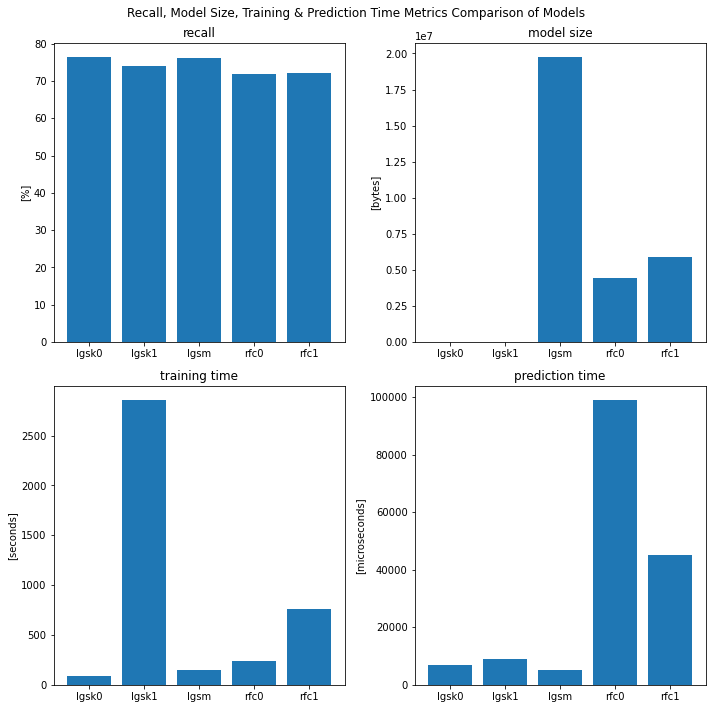

In [325]:
# Summary of all five models in terms of Recall, Size of Model, Training and Prediction Running time
Model_list = ['lgsk0', 'lgsk1', 'lgsm', 'rfc0', 'rfc1']
Recall_list = [lgsk_report0_df.loc['1', 'recall'], 
               lgsk_report1_df.loc['1', 'recall'], 
               lgsm_report1_df.loc['1', 'recall'], 
               rfc_report0_df.loc['1', 'recall'], 
               rfc_report1_df.loc['1', 'recall']]
# to convert recall to %
# https://stackoverflow.com/questions/26446338/how-to-multiply-all-integers-inside-list
Recall_list = [Recall_list* 100 for Recall_list in Recall_list]
Model_size_list = [lgsk_size0, lgsk_size1, lgsm_size1, rfc_size0,  rfc_size1]

# need to convert timedelta to int in a dataframe
# https://stackoverflow.com/questions/25646200/python-convert-timedelta-to-int-in-a-dataframe
Train_run_time_list = [lgsk_train_run_time0.seconds, 
                       lgsk_train_run_time1.seconds, 
                       lgsm_train_run_time1.seconds, 
                       rfc_train_run_time0.seconds, 
                       rfc_train_run_time1.seconds]
Prediction_run_time_list = [lgsk_run_time0.microseconds, 
                            lgsk_run_time1.microseconds, 
                            lgsm_run_time1.microseconds, 
                            rfc_run_time0.microseconds, 
                            rfc_run_time1.microseconds]

# plot all metrics comparison for all five models using subplot
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Recall, Model Size, Training & Prediction Time Metrics Comparison of Models')
axs[0, 0].bar(Model_list, Recall_list)
axs[0, 0].set_title('recall')
axs[0, 0].set_ylabel('[%]')
axs[0, 1].bar(Model_list, Model_size_list)
axs[0, 1].set_title('model size')
axs[0, 1].set_ylabel('[bytes]')
axs[1, 0].bar(Model_list, Train_run_time_list)
axs[1, 0].set_title('training time')
axs[1, 0].set_ylabel('[seconds]')
axs[1, 1].bar(Model_list, Prediction_run_time_list)
axs[1, 1].set_title('prediction time')
axs[1, 1].set_ylabel('[microseconds]')

fig.tight_layout()

#for ax in axs.flat:
    #ax.set(xlabel='Model', ylabel='Metric value')
# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
    #ax.label_outer()

In [340]:
Recall_list, Model_size_list, 

([76.29629629629629,
  74.07407407407408,
  76.11111111111111,
  71.85185185185186,
  72.03703703703704],
 [4835, 23000, 19722725, 4456616, 5927796])

Simpler sklearn's logistic regression (lgsk0) model resulted in highest recall (\~76%), lowest model size (4.8k bytes),  shortest training time (~1.5 min), 2nd to shorted prediction time (few microseconds). Therefore, Simpler sklearn's logistic regression (lgsk0) should be used for further analysis (feature importance analysis.)

### 3.7.2 Threshhold Analysis and Predicted Probabilites Distribution

In [267]:
# code provided by mentor, Julian
def threshold_and_plot(y_test, target, n_points=50, plot=True):
    """
    :param y_test: binary vector of actual targets
    :param target: vector of probabilities
    :param n_points: number of points to evaluate for a threshold
    :param plot: Boolean; whether or not to plot the results
    :return: vector of values of precision, recall, F1 for given points
    """
    # plot the value of the metric against the threshold
    # plt.figure(figsize=(12,12))
    probs = np.linspace(0, 1, n_points)
    def make_thresh():  # try n_points = 50 or 100...
        # calculate each metric here
        precision = [metrics.precision_score(y_test, np.where(target > thresh, 1, 0)) for thresh in probs]
        recall = [metrics.recall_score(y_test, np.where(target > thresh, 1, 0)) for thresh in probs]
        f1 = [metrics.f1_score(y_test, np.where(target > thresh, 1, 0)) for thresh in probs]
        return precision, recall, f1

    precision, recall, f1 = make_thresh()
    if plot:
        plt.plot(probs, precision, label='precision')
        plt.plot(probs, recall, label='recall')
        plt.plot(probs, f1, label='f1')
        plt.title("Metrics at various thresholds");
        plt.xlabel("Probability");
        plt.ylabel("Metric value");
        plt.legend();
        # print("Precision: {:.3f}; Recall: {:.3f}; F1: {:.3f}".format(precision, recall, f1))
        return precision, recall, f1
    else:
        return precision, recall, f1

def max_thresh(score_vec):
    max_idx = np.argmax(score_vec)
    max_score = score_vec[max_idx]
    return max_idx, max_score

In [268]:
# function to....
# check the distributions of predicted values (probabilities)
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
def prob_dist_plot(pred, prob):  
    # make dataframe to use sns to plot & color by value
    data = {'Prediction': pred, 'Probability': prob};
    df = pd.DataFrame(data);
    df['Index'] = df.index;
    # https://seaborn.pydata.org/generated/seaborn.scatterplot.html
    sns.scatterplot(data=df, x='Index', y='Probability', hue='Prediction').set(title='Predicted Probabilities Distribution')
    return

#### 3.7.2.1 Test random data

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.609


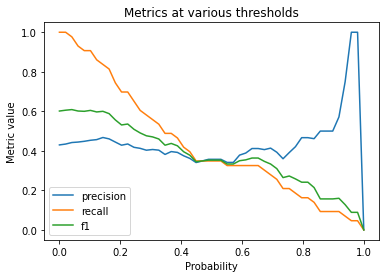

In [269]:
# Test random data
y_test_random=  np.random.choice([0, 1], 100, replace=True)
test_random_prob = np.random.uniform(0., 1., 100)
test_random_thresh = threshold_and_plot(y_test_random, test_random_prob, 50)

# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], test_random_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")

#### 3.7.2.2 logistic regreassion via sklearn

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.996


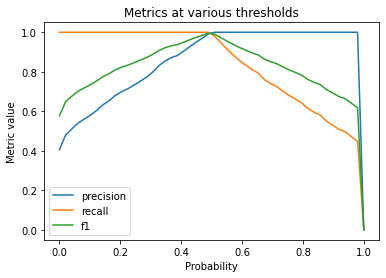

In [270]:
# logistic regreassion via sklearn 1
# predicting probabilities
#%%%% lg_y_pred0 = logreg_best0.predict(X_test_mean_scaled_odmb)
#%%%% The predict() method gives binary values (using a default of p > 0.5 = 1) instead of probabilities 
'''
https://www.kaggle.com/c/dont-overfit-ii/discussion/90656
The function predict_proba() returns a numpy array of two columns. 
The first column is the probability that target=0 and the second column is the probability that target=1. 
That is why we add [:,1] after predict_proba() in order to get the probabilities of target=1.
'''
lg_y_prob0 = logreg_best0.predict_proba(X_test_mean_scaled_odmb)
logreg0_thresh = threshold_and_plot(lg_y_pred0, lg_y_prob0[:,1], 50)
# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], logreg0_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")

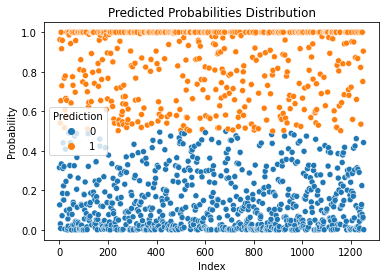

In [271]:
# check the distributions of predicted values (probabilities)
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
prob_dist_plot(lg_y_pred0, lg_y_prob0[:,1])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.994


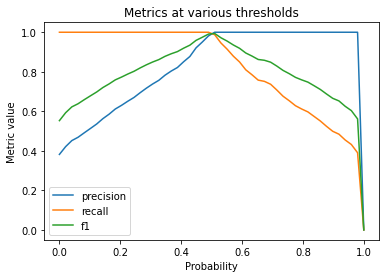

In [272]:
# logistic regreassion via sklearn 2
lg_y_prob1 = logreg_best1.predict_proba(X_test_mean_scaled_odmb)
logreg1_thresh = threshold_and_plot(lg_y_pred1, lg_y_prob1[:,1], 50)
# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], logreg1_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")

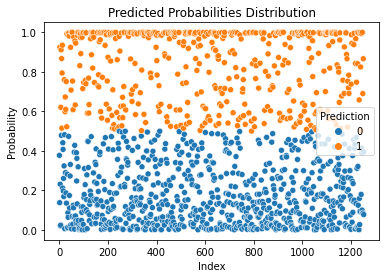

In [273]:
# check the distributions of predicted values (probabilities)
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
prob_dist_plot(lg_y_pred1, lg_y_prob1[:,1])

#### 3.7.2.3 logistic regreassion via statsmodel

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.995


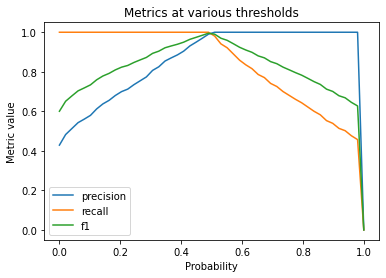

In [274]:
# logistic regreassion via statsmodel
#%%%%% how to get probability for statsmodel? > 
# y_pred1 = log_reg1.predict(X_test_mean_scaled_odmb_c_dirty) > the default output of statsmodel predict is 'probability'
lgsm_thresh = threshold_and_plot(y_pred1_df.prediction, y_pred1, 50) # y_pred1_df.prediction.shape, y_pred1.shape > (1254,)
# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], lgsm_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")

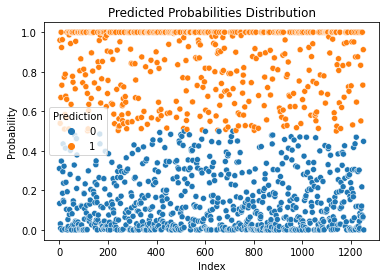

In [275]:
# check the distributions of predicted values (probabilities)
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
prob_dist_plot(y_pred1_df.prediction, y_pred1)

#### 3.7.2.4 Random forest model via sklearn

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.990


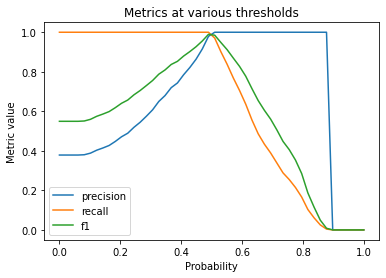

In [276]:
# Random forest model 1
rfc_y_prob0 = rfc_best0.predict_proba(X_test_mean_scaled_odmb)
rfc0_thresh = threshold_and_plot(rfc_y_pred0, rfc_y_prob0[:,1], 50)
# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], rfc0_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")

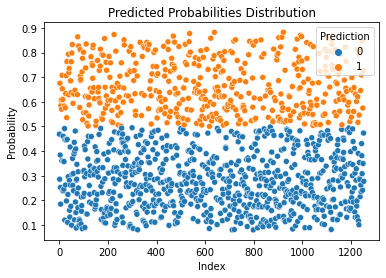

In [277]:
# check the distributions of predicted values (probabilities)
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
prob_dist_plot(rfc_y_pred0, rfc_y_prob0[:,1])

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Maximum Precision:1.000
Maximum Recall:1.000
Maximum F1:0.987


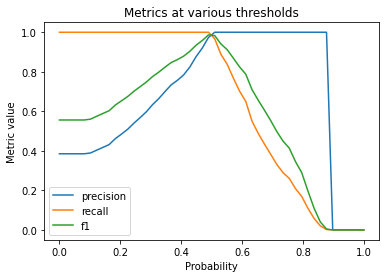

In [278]:
# Random forest model 2
rfc_y_prob1 = rfc_best1.predict_proba(X_test_mean_scaled_odmb)
rfc1_thresh = threshold_and_plot(rfc_y_pred1, rfc_y_prob1[:,1], 50)
# print out the maximum value
# assumes that "test_metrics" is a tuple to be unpacked
for metric, val in zip(["Precision", "Recall", "F1"], rfc1_thresh):
  _, max_val = max_thresh(val)
  print(f"Maximum {metric}:{max_val:.3f}")

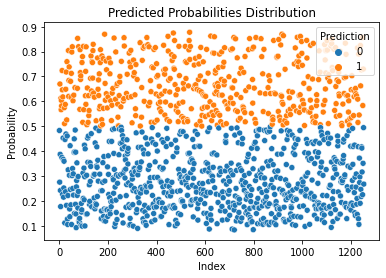

In [279]:
# check the distributions of predicted values (probabilities)
# plot the distribution of predicted probabilities and then color/highlight with the observed labels.
prob_dist_plot(rfc_y_pred1, rfc_y_prob1[:,1])

### 3.7.3 Fit Null Model

#### 3.7.3.1 logistic regreassion via sklearn 

In [280]:
# code by Julian
# naive model: random guesses using the intercept
# use default params for regression
X_null_train = np.ones(shape=y_train.shape[0]).reshape(-1,1) # intercept
X_null_test = np.ones(shape=y_test.shape[0]).reshape(-1,1) # intercept

# logistic regreassion via sklearn
null_lgsk = LogisticRegression(fit_intercept=False) 
# fit on train and test data
null_train_lgsk = null_lgsk.fit(X=X_null_train, y=y_train)
null_test_lgsk = null_lgsk.fit(X=X_null_test, y=y_test)

null_train_pred_lgsk = null_train_lgsk.predict(X_null_train)
null_test_pred_lgsk = null_test_lgsk.predict(X_null_test)

In [281]:
# TODO: confusion matrix (default prob) and precision, recall, F1
# Train dataset
print(confusion_matrix(y_train, null_train_pred_lgsk))
print(classification_report(y_train, null_train_pred_lgsk))
print('Mean of target train dataset: ', y_train.mean())

[[2872    0]
 [2140    0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      2872
           1       0.00      0.00      0.00      2140

    accuracy                           0.57      5012
   macro avg       0.29      0.50      0.36      5012
weighted avg       0.33      0.57      0.42      5012

Mean of target train dataset:  0.42697525937749403


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [282]:
# Test dataset
print(confusion_matrix(y_test, null_test_pred_lgsk))
print(classification_report(y_test, null_test_pred_lgsk))
print('Mean of target test dataset: ', y_test.mean())

[[714   0]
 [540   0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       714
           1       0.00      0.00      0.00       540

    accuracy                           0.57      1254
   macro avg       0.28      0.50      0.36      1254
weighted avg       0.32      0.57      0.41      1254

Mean of target test dataset:  0.430622009569378


#### 3.7.3.2 logistic regreassion via stasmodel

In [283]:
# logistic regreassion via stasmodel
# log_reg1 = sm.Logit(y_train, X_train_mean_scaled_odmb_c_dirty).fit_regularized()
# fit on train and test data
null_train_lgsm = sm.Logit(y_train, X_null_train).fit_regularized() # do I need to add constant?
null_test_lgsm = sm.Logit(y_test, X_null_test).fit_regularized()

# y_pred1 = log_reg1.predict(X_test_mean_scaled_odmb_c_dirty)
null_train_pred_lgsm = null_train_lgsm.predict(X_null_train) # need to convert this probability to binanry prediction
null_test_pred_lgsm = null_test_lgsm.predict(X_null_test)

# should convert this probability to 0 (p < 0.5), or 1 (p >= 0.5) 
# in order to compute the confusion matrix and classification report (check the sklearn ym_pred output above)
null_train_pred_lgsm_df = pd.DataFrame({'probability': null_train_pred_lgsm})
null_train_pred_lgsm_df['prediction'] = [0 if row < 0.5 else 1 for row in null_train_pred_lgsm_df.probability] 

null_test_pred_lgsm_df = pd.DataFrame({'probability': null_test_pred_lgsm})
null_test_pred_lgsm_df['prediction'] = [0 if row < 0.5 else 1 for row in null_test_pred_lgsm_df.probability] 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6824437121518183
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.683489438523392
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5


In [284]:
# TODO: confusion matrix (default prob) and precision, recall, F1
# Train dataset
print(confusion_matrix(y_train, null_train_pred_lgsm_df.prediction))
print(classification_report(y_train, null_train_pred_lgsm_df.prediction))

[[2872    0]
 [2140    0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      2872
           1       0.00      0.00      0.00      2140

    accuracy                           0.57      5012
   macro avg       0.29      0.50      0.36      5012
weighted avg       0.33      0.57      0.42      5012



In [285]:
# Test dataset
print(confusion_matrix(y_test, null_test_pred_lgsm_df.prediction))
print(classification_report(y_test, null_test_pred_lgsm_df.prediction))

[[714   0]
 [540   0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       714
           1       0.00      0.00      0.00       540

    accuracy                           0.57      1254
   macro avg       0.28      0.50      0.36      1254
weighted avg       0.32      0.57      0.41      1254



#### 3.7.3.3 Random forest model via sklearn

In [286]:
# Random forest model via sklearn
# rfc0 = RandomForestClassifier(random_state = 1234)
null_rfc = RandomForestClassifier() #%%%% removed fit_intercept=False
# fit on train and test data
null_train_rfc = null_rfc.fit(X=X_null_train, y=y_train)
null_test_rfc = null_rfc.fit(X=X_null_test, y=y_test)

null_train_pred_rfc = null_train_rfc.predict(X_null_train)
null_test_pred_rfc = null_test_rfc.predict(X_null_test)

In [287]:
# TODO: confusion matrix (default prob) and precision, recall, F1
# Train dataset
print(confusion_matrix(y_train, null_train_pred_rfc))
print(classification_report(y_train, null_train_pred_rfc))

[[2872    0]
 [2140    0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      2872
           1       0.00      0.00      0.00      2140

    accuracy                           0.57      5012
   macro avg       0.29      0.50      0.36      5012
weighted avg       0.33      0.57      0.42      5012



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [288]:
# Test dataset
print(confusion_matrix(y_test, null_test_pred_rfc))
print(classification_report(y_test, null_test_pred_rfc))

[[714   0]
 [540   0]]
              precision    recall  f1-score   support

           0       0.57      1.00      0.73       714
           1       0.00      0.00      0.00       540

    accuracy                           0.57      1254
   macro avg       0.28      0.50      0.36      1254
weighted avg       0.32      0.57      0.41      1254



## 3.8 Conclusion
Most powerful model in terms of model evaluation metrics, computational complexity, scalability, and maintenance costs is the simpler sklearn's logistic regression (lgsk0) model resulted in highest recall (\~76%), lowest model size (4.8k bytes), shortest training time (~1.5 min), 2nd to shorted prediction time (few microseconds). 
- from nature of model, logistic regression model will be more scalable than random forest model (more complicated the tree models, takes up more storage space than logistic regression model). 

### reference
- sklearn codes:
    - '14.1.2_3_Supervised Learning_Tuning': logisticRegression, confusion_matrix, classification_report, 
    - '14.1.2_4_Supervised Learning with scikit-learn_Preprocessing and Pipeline': buiding pipeline, scaler, get_dummies() 
    - '6_GuidedCapstone/04_preprocessing_and_training_mk': scaler, Random Forest model
     - '14.2.11_Case Study - Logistic Regression/Logistic Regression Advanced Case Study_mk': plot logisticRegression output.
- Statsmodel codes:
    - '11.4.1_Case Study - Linear Regression/Regression Case Study - the Red Wine Dataset - Tier 3_mk': sm.OLS(y, X), plot predictions (y_test vs. y_pred)
- Random Forest model codes:'14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
    - '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk'
    - '14.3.5_Case Study - Decision Trees - RR Diner Coffee/Decision Tree Specialty Coffee Case Study - Tier 3_mk'
    
- refer to 'https://pandas.pydata.org/pandas-docs/version/0.24.0rc1/api/generated/pandas.Series.to_numpy.html'
    - series to numpy: s.to_numpy()
- data preprocessing: 
    - '14.4.4 Case Study - Random Forest/RandomForest_casestudy_covid19_mk': get_dummies(), sklearn scaler
    - '14.5.6_Case Study - Gradient Boosting/Gradient Boosting Case Study_mk': exctract categorical data
    - '15.4.3_3_Unsupervised Learning_Dimension reduction': PCA
- feature importance interpretation: SHAP
    - https://aigerimshopenova.medium.com/random-forest-classifier-and-shap-how-to-understand-your-customers-and-interpret-a-black-box-model-6166d86820d9
    - https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
    - https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
    - https://ff06-2020.fastforwardlabs.com/
   

### Questions:
- how do perform cross validation on statsmodel?
    - Answers:
    - currently not avaliable(can't perform cross validation using statsmodels.api yet) and is not compatibible with sklearn cross_val_score or GredSearchCV...etc
    - need to write custom codes if you really want to
    - people usually use sklearn for building ML model.
    - statsmodel is used for quick stats calculation from a model than model optimazation. 
- how to use ElasticNet in sklearn LogisticRegression? (currently only l1 or l2 are available!?)
    - Answers:
    - need to change the default solver (lbfgs) to saga in order to use elasticnet
        - param_grid = {'C': c_space, 'penalty': ['elasticnet'], 'l1_ratio': l1_space} 
        - logreg = LogisticRegression(solver='saga', max_iter=10000) 
        - logreg_cv = GridSearchCV(logreg, param_grid, cv=5)
- how to compare the performance of statsmodel and sklearn lotistic model
    - Answers:
    - use sklearn confusion_matrix, classification_report on the y_pred, y_test
    - need to convert the statsmodel's y_pred in probability to binary system (0,1) in advance
    
- how to choose scoring system for GridSearhCV like we can do for cross_val_score? (what is the defaut score?, accuracy?)
    - cv_accuracy = cross_val_score(clf, Xlr, ylr, cv=5, scoring='accuracy')
    - cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
    - Answers:
    - use GridSearhCV(logreg, param_grid, scoring = 'roc_auc', cv=5), default scoring = 'accuracy'
    - should not use 'accuracy' scoring for data with imbalanced disribution.
    - for logistic regression, target variable (0,1), 
        - one opinion: if there is much more (more than 10x!?) 1 than 0 (or vice verso) > imbalanced data
        - another opinion: accuracy for 50:50 balance data is fine, if there is 60:40 > imbalanced data, and start to doubt the accuracy as metric, and use log loss as metric instead.
- for logistic regression model, do I need to leave all the binary variable (or only dependent variable) out for scaling.
    - Answers: 
    - leaving it out all the binary viarable for scaling for logistic regression model might be better!?
- how to measure size of model? 
    - import sys 
    - ie) sys.getsizeof(logreg_best0)
- How to save %%time, model running time? Just input manually 
    - it's ok to take a long time to training the data set. 
    - need to separate how the prediction code and compare the time take for prediciton for each model.
    - start_time = datetime.datetime.now(): need to put this right before
    - run_time = datetime.datetime.now() - start_time: need to put this right after the code want to meature the time
- which matrix to compare within classification report?
    - If cost to give wrong recommendation is high, then precison is important in the recommendation prediction system than recall (recall is often more important for marketing prediction system).
    - if rhere is no precison/recall preference, ROC is often compared.